In [9]:
# """
# predicting a sequence of future prices (`n_steps_out`) instead of just one.

# Benefits of This Approach
# Utilizes Temporal Patterns: The model learns dependencies across multiple future time steps.
# More Robust Predictions: Predicting a sequence captures trends better than single-step predictions.
# Real-World Applicability: Multi-step forecasting is closer to real-world use cases, such as portfolio management.
# """

time: 533 µs (started: 2024-11-18 07:56:36 +00:00)


In [10]:
!pip install -r requirements.txt -q
!pip install ipython-autotime -q

time: 8.84 s (started: 2024-11-18 07:56:36 +00:00)


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import math
import matplotlib.pyplot as plt
import joblib
from joblib import Parallel, delayed
from pathlib import Path

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.layers import Input, Dense, Dropout, BatchNormalization, Reshape, Flatten, Bidirectional, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

%matplotlib inline
%load_ext autotime

print("tensorflow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

2024-11-18 08:52:12.544381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 08:52:12.544506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 08:52:12.546902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 08:52:12.561777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-18 08:52:13.956676: W tensorflow/compiler/tf2

tensorflow version: 2.15.0
Num GPUs Available:  1


2024-11-18 08:52:16.433111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 08:52:16.482095: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-18 08:52:16.482415: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

True

time: 95.9 ms (started: 2024-11-18 08:52:16 +00:00)


In [2]:
def load_processed_data(data_dir='processed_data'):
    """
    Load processed DataFrames list and numpy arrays from files
    """
    data_path = Path(data_dir)
    
    # Load list of DataFrames
    with open(data_path / 'processed_dfs.pkl', 'rb') as f:
        processed_dfs = joblib.load(f)
    
    # Load numpy arrays
    values_path = data_path / 'values_array.npy'
    values_list = np.load(values_path, allow_pickle=True)
    
    return processed_dfs, values_list

processed_dfs, values_list = load_processed_data('processed_data')

time: 89.1 ms (started: 2024-11-18 08:52:16 +00:00)


In [3]:
processed_dfs[0]

Price,Adj Close,Close,High,Low,Open,Volume,RSI,WR,SMA7,SMA14,...,EMA7,EMA25,EMA99,EMA200,MACD,CCI,Upper Band,Lower Band,Ulcer Index,Close Next Day
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-08-19 00:00:00+00:00,25.937435,28.752501,29.129999,28.670000,29.025000,193146000,38.868505,-58.647164,28.875357,29.083214,...,29.011843,29.811806,30.819353,30.361521,-0.639367,-59.662038,30.115768,28.050661,8.949397,28.162500
2015-08-20 00:00:00+00:00,25.405201,28.162500,28.587500,27.907499,28.520000,274006400,34.842467,-76.661486,28.845357,28.928750,...,28.799508,29.684936,30.766216,30.339640,-0.675706,-101.719165,29.807586,28.049914,8.822285,26.440001
2015-08-21 00:00:00+00:00,23.851353,26.440001,27.975000,26.412500,27.607500,513102000,26.282999,-99.232910,28.506786,28.702321,...,28.209631,29.435326,30.679692,30.300837,-0.833884,-193.641185,30.187027,27.217616,8.940749,25.780001
2015-08-24 00:00:00+00:00,23.255964,25.780001,27.200001,23.000000,23.717501,648825200,23.863926,-60.271513,28.077143,28.496607,...,27.602223,29.154147,30.581698,30.255854,-1.000959,-286.791374,30.611922,26.381293,9.012688,25.934999
2015-08-25 00:00:00+00:00,23.395788,25.934999,27.777500,25.875000,27.777500,414406400,25.595895,-58.056453,27.640715,28.288393,...,27.185417,28.906520,30.488764,30.212860,-1.108087,-175.033141,30.766350,25.810436,9.087065,27.422501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-25 00:00:00+00:00,231.155685,231.410004,233.220001,229.570007,229.740005,38802300,53.621399,-42.696626,233.175714,231.504286,...,232.117849,229.678046,219.220789,207.361942,2.040117,34.671127,237.405189,225.603382,1.664750,233.399994
2024-10-28 00:00:00+00:00,233.143494,233.399994,234.729996,232.550003,233.320007,36087100,56.742652,-32.306559,233.354285,232.049285,...,232.438385,229.964350,219.504373,207.621027,2.033819,76.852796,237.075664,227.022906,1.484857,233.669998


time: 40.7 ms (started: 2024-11-18 08:52:16 +00:00)


In [6]:
def preprocess_stock_data(values_list, n_steps_in=14, n_steps_out=5, train_split=0.8):
    """
    Preprocess multiple stock datasets for LSTM training.
    
    Args:
        values_list: List of numpy arrays containing stock data with technical indicators
        n_steps_in: Number of lookback days
        n_steps_out: Number of prediction days
        train_split: Train/validation split ratio
        
    Returns:
        tuple: (train_X, train_y, val_X, val_y, global_scaler)
    """
    # 1. Global scaling across all stocks
    global_scaler = MinMaxScaler(feature_range=(0, 1))
    combined_values = np.vstack(values_list)
    scaled_combined = global_scaler.fit_transform(combined_values)
    
    # 2. Split back into individual stocks
    scaled_values_list = []
    start_idx = 0
    for values in values_list:
        scaled_values_list.append(scaled_combined[start_idx:start_idx + len(values)])
        start_idx += len(values)
    
    # 3. Create sequences for each stock
    train_X_list, train_y_list = [], []
    val_X_list, val_y_list = [], []
    
    for scaled_values in scaled_values_list:
        # Split into train/validation
        n_train = int(len(scaled_values) * train_split)
        
        # Ensure we have enough data for both training and validation
        if n_train <= n_steps_in + n_steps_out:
            print(f"Warning: Stock with {len(scaled_values)} samples is too short for meaningful splitting")
            continue
            
        train_data = scaled_values[:n_train]
        val_data = scaled_values[n_train:]
        
        # Create sequences
        if len(train_data) > n_steps_in + n_steps_out:
            train_X, train_y = create_sequences(train_data, n_steps_in, n_steps_out)
            train_X_list.append(train_X)
            train_y_list.append(train_y)
            
        if len(val_data) > n_steps_in + n_steps_out:
            val_X, val_y = create_sequences(val_data, n_steps_in, n_steps_out)
            val_X_list.append(val_X)
            val_y_list.append(val_y)
    
    # 4. Combine all sequences
    train_X = np.vstack(train_X_list)
    train_y = np.vstack(train_y_list)
    val_X = np.vstack(val_X_list)
    val_y = np.vstack(val_y_list)
    
    print(f"Training shapes: X={train_X.shape}, y={train_y.shape}")
    print(f"Validation shapes: X={val_X.shape}, y={val_y.shape}")
    
    return train_X, train_y, val_X, val_y, global_scaler

def create_sequences(data, n_steps_in, n_steps_out):
    """
    Generate sequences for LSTM input and output.
    
    Args:
        data: Scaled data (numpy array)
        n_steps_in: Number of input time steps
        n_steps_out: Number of output time steps
        
    Returns:
        tuple: (X sequences, y sequences)
    """
    X, y = [], []
    
    # Ensure we have enough data for sequence creation
    if len(data) < n_steps_in + n_steps_out:
        raise ValueError("Data length is too short for the specified sequence lengths")
    
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        # Input sequence (n_steps_in days of all features)
        seq_x = data[i:(i + n_steps_in)]
        # Output sequence (n_steps_out days of target variable)
        seq_y = data[(i + n_steps_in):(i + n_steps_in + n_steps_out), -1]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


n_steps_in = 14  # Number of days to look back
n_steps_out = 5  # Number of days to predict ahead

train_X, train_y, val_X, val_y, scaler = preprocess_stock_data(
    values_list,
    n_steps_in,
    n_steps_out,
    train_split=0.8
)

Training shapes: X=(34865, 14, 21), y=(34865, 5)
Validation shapes: X=(8474, 14, 21), y=(8474, 5)
time: 189 ms (started: 2024-11-18 08:53:46 +00:00)


In [ ]:
def create_lstm_model(n_steps_in, n_features, n_steps_out):
    """
    Create LSTM model for stock price prediction.
    
    Args:
        n_steps_in: Number of input time steps
        n_features: Number of features
        n_steps_out: Number of prediction days
        
    Returns:
        model: Compiled LSTM model
    """
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)),
        Dense(n_steps_out)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mae')
    
    return model

# Create and train model
model = create_lstm_model(
    n_steps_in,
    n_features=train_X.shape[2],
    n_steps_out
)

In [16]:
# Train model
history = model.fit(
    train_X,
    train_y,
    validation_data=(val_X, val_y),
    epochs=50,
    batch_size=64,
    verbose=2,
    shuffle=False
)

Epoch 1/50


2024-11-18 07:56:52.662046: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-11-18 07:56:52.839877: I external/local_xla/xla/service/service.cc:168] XLA service 0x317fa6f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-18 07:56:52.839944: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro P5000, Compute Capability 6.1
2024-11-18 07:56:52.857849: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731916613.047342    6577 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 - 9s - loss: 0.0415 - val_loss: 0.0289 - 9s/epoch - 16ms/step
Epoch 2/50
545/545 - 3s - loss: 0.0153 - val_loss: 0.0226 - 3s/epoch - 6ms/step
Epoch 3/50
545/545 - 4s - loss: 0.0119 - val_loss: 0.0205 - 4s/epoch - 7ms/step
Epoch 4/50
545/545 - 4s - loss: 0.0105 - val_loss: 0.0194 - 4s/epoch - 6ms/step
Epoch 5/50
545/545 - 3s - loss: 0.0096 - val_loss: 0.0175 - 3s/epoch - 6ms/step
Epoch 6/50
545/545 - 3s - loss: 0.0088 - val_loss: 0.0164 - 3s/epoch - 6ms/step
Epoch 7/50
545/545 - 4s - loss: 0.0082 - val_loss: 0.0153 - 4s/epoch - 8ms/step
Epoch 8/50
545/545 - 4s - loss: 0.0078 - val_loss: 0.0146 - 4s/epoch - 8ms/step
Epoch 9/50
545/545 - 4s - loss: 0.0075 - val_loss: 0.0140 - 4s/epoch - 8ms/step
Epoch 10/50
545/545 - 4s - loss: 0.0072 - val_loss: 0.0132 - 4s/epoch - 8ms/step
Epoch 11/50
545/545 - 5s - loss: 0.0070 - val_loss: 0.0134 - 5s/epoch - 8ms/step
Epoch 12/50
545/545 - 4s - loss: 0.0068 - val_loss: 0.0135 - 4s/epoch - 8ms/step
Epoch 13/50
545/545 - 4s - loss: 0.0066 - val_l

In [17]:
# Make predictions
y_pred = model.predict(val_X)

# Evaluate for each time step
for i in range(n_steps_out):
    mae = np.mean(np.abs(val_y[:, i] - y_pred[:, i]))
    print(f"MAE for step {i+1}: {mae: .4f}")

265/265 [==============================] - 2s 4ms/step
MAE for step 1:  0.0137
MAE for step 2:  0.0078
MAE for step 3:  0.0119
MAE for step 4:  0.0131
MAE for step 5:  0.0130
time: 2.16 s (started: 2024-11-18 08:00:15 +00:00)


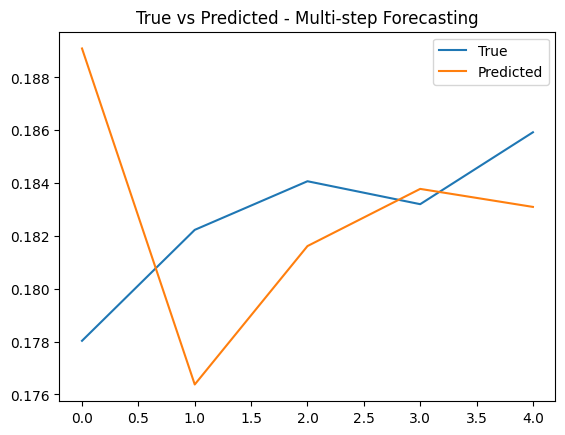

time: 303 ms (started: 2024-11-18 08:00:17 +00:00)


In [18]:
import matplotlib.pyplot as plt

# Plot example sequence
plt.plot(val_y[0], label='True')
plt.plot(y_pred[0], label='Predicted')
plt.legend()
plt.title('True vs Predicted - Multi-step Forecasting')
plt.show()


Analyzing AAPL...

Evaluation Metrics for AAPL:
MSE: 155.6909
RMSE: 12.4776
MAE:  11.8556


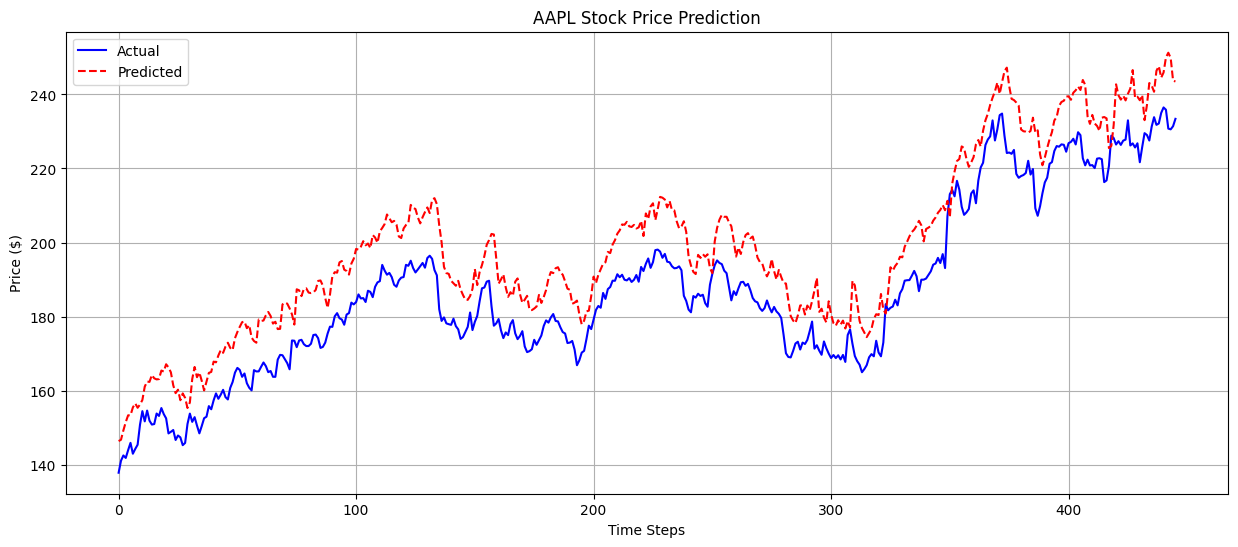


Analyzing AMZN...

Evaluation Metrics for AMZN:
MSE: 158.2880
RMSE: 12.5813
MAE:  11.9271


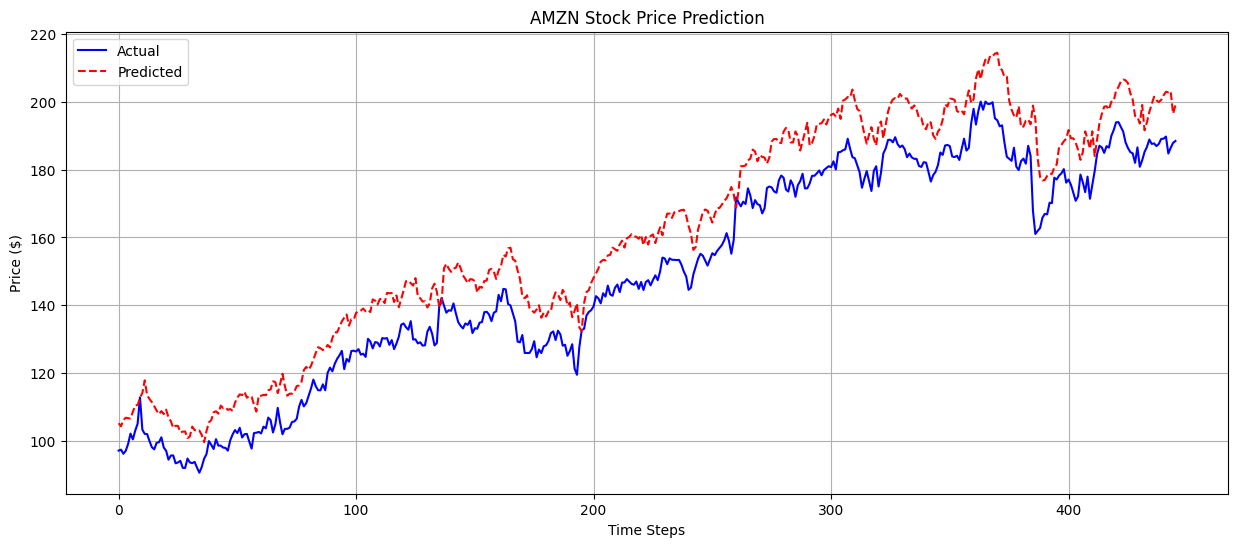


Analyzing GME...

Evaluation Metrics for GME:
MSE: 36.8630
RMSE: 6.0715
MAE:  5.7205


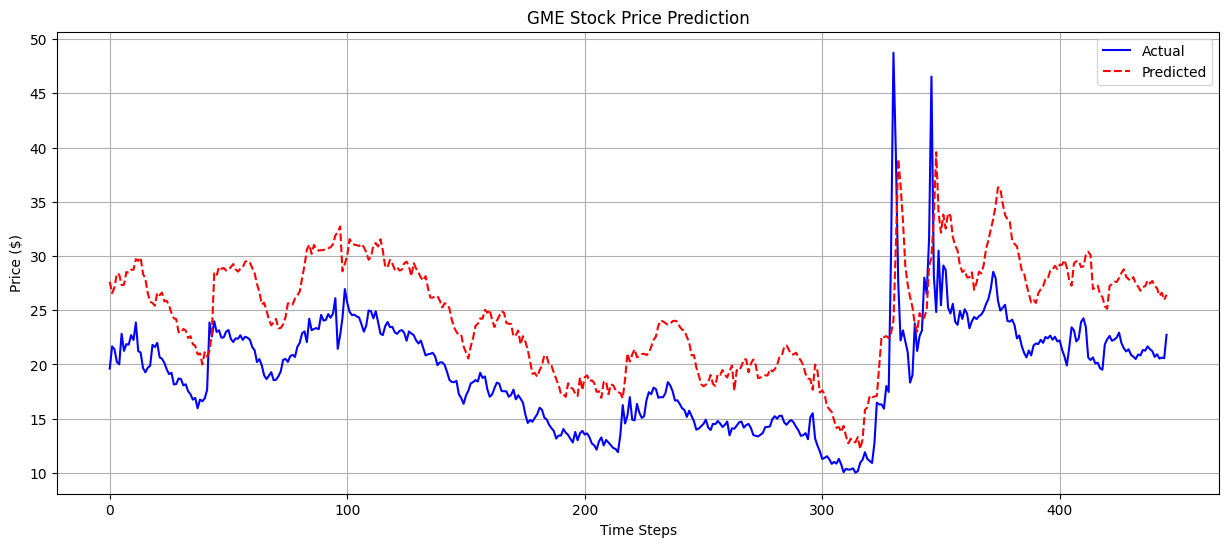


Analyzing GOOGL...

Evaluation Metrics for GOOGL:
MSE: 155.8200
RMSE: 12.4828
MAE:  11.9177


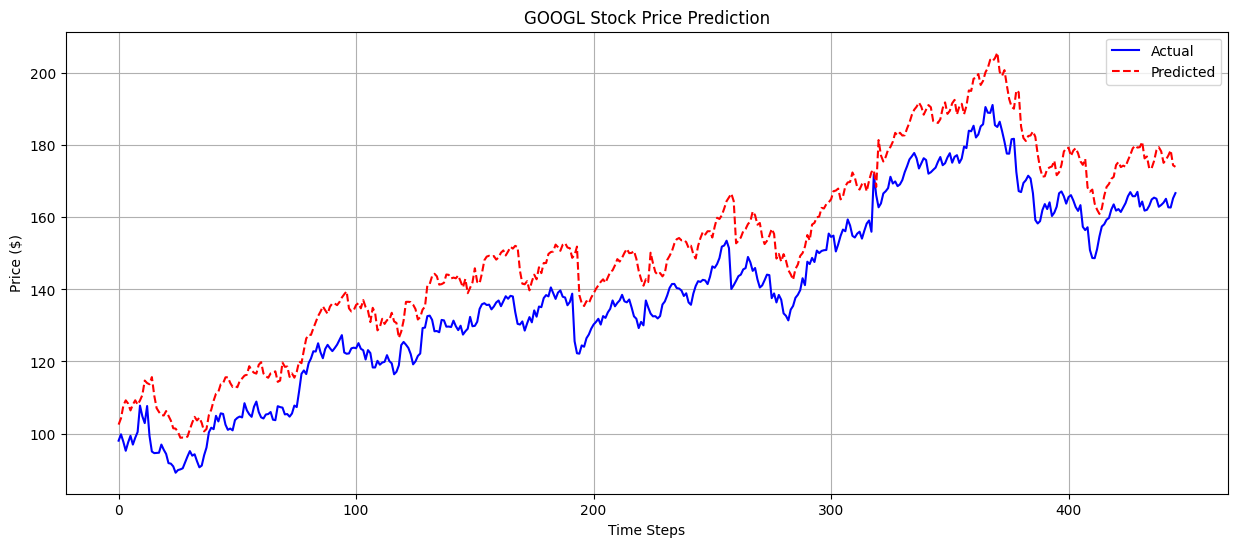


Analyzing NFLX...

Evaluation Metrics for NFLX:
MSE: 428.7137
RMSE: 20.7054
MAE:  15.5696


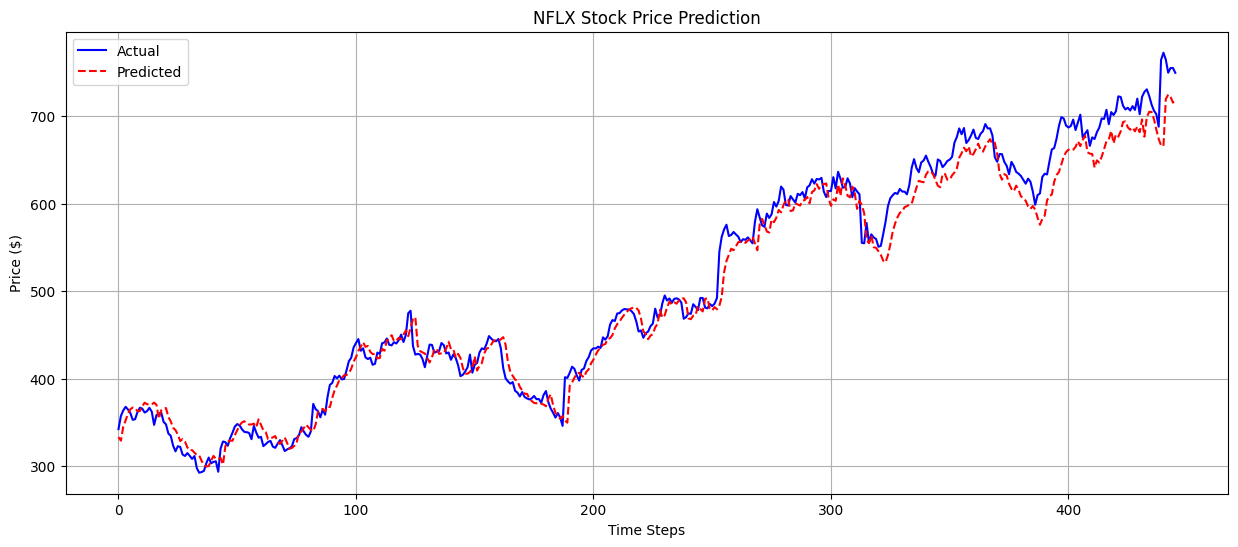


Analyzing TSLA...

Evaluation Metrics for TSLA:
MSE: 205.4866
RMSE: 14.3348
MAE:  11.7986


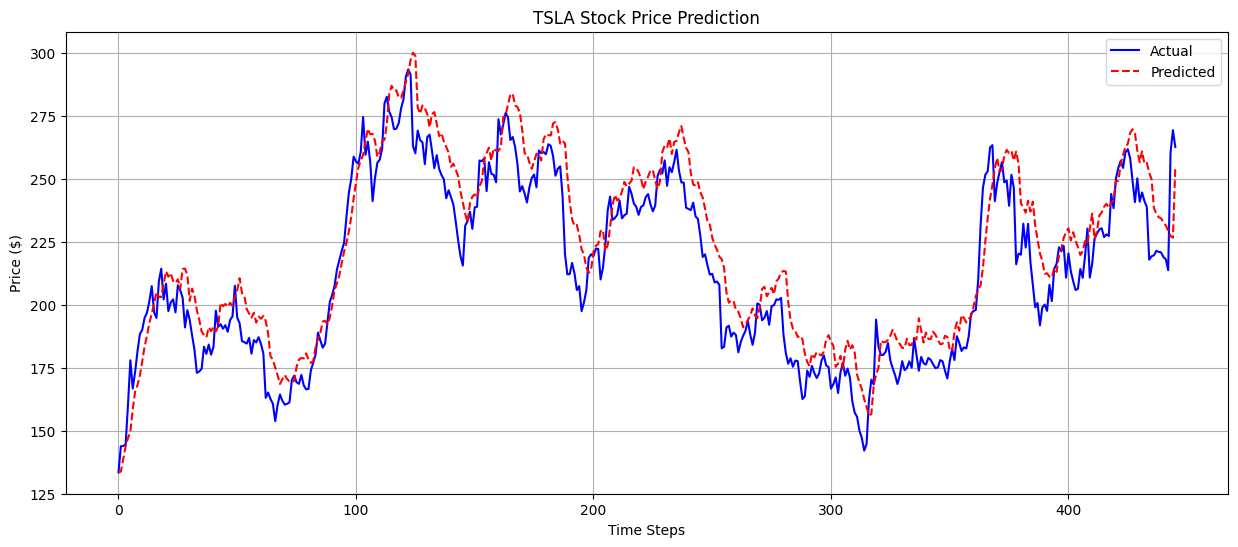


Analyzing MSFT...

Evaluation Metrics for MSFT:
MSE: 77.7667
RMSE: 8.8185
MAE:  7.0974


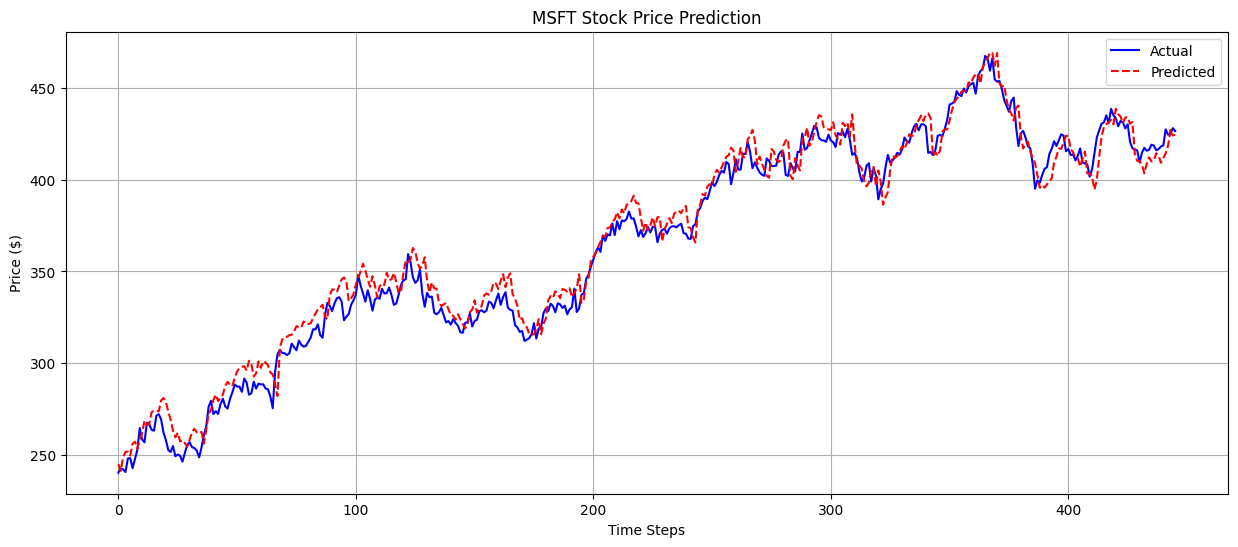


Analyzing NVDA...

Evaluation Metrics for NVDA:
MSE: 65.1743
RMSE: 8.0731
MAE:  7.0273


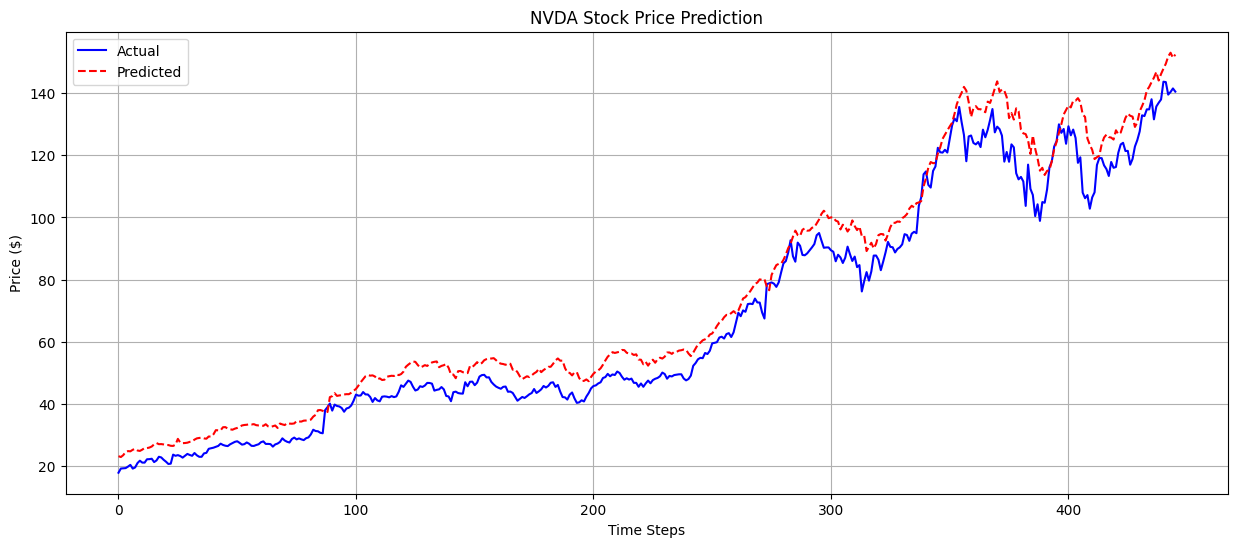


Analyzing AMD...

Evaluation Metrics for AMD:
MSE: 157.3818
RMSE: 12.5452
MAE:  11.0884


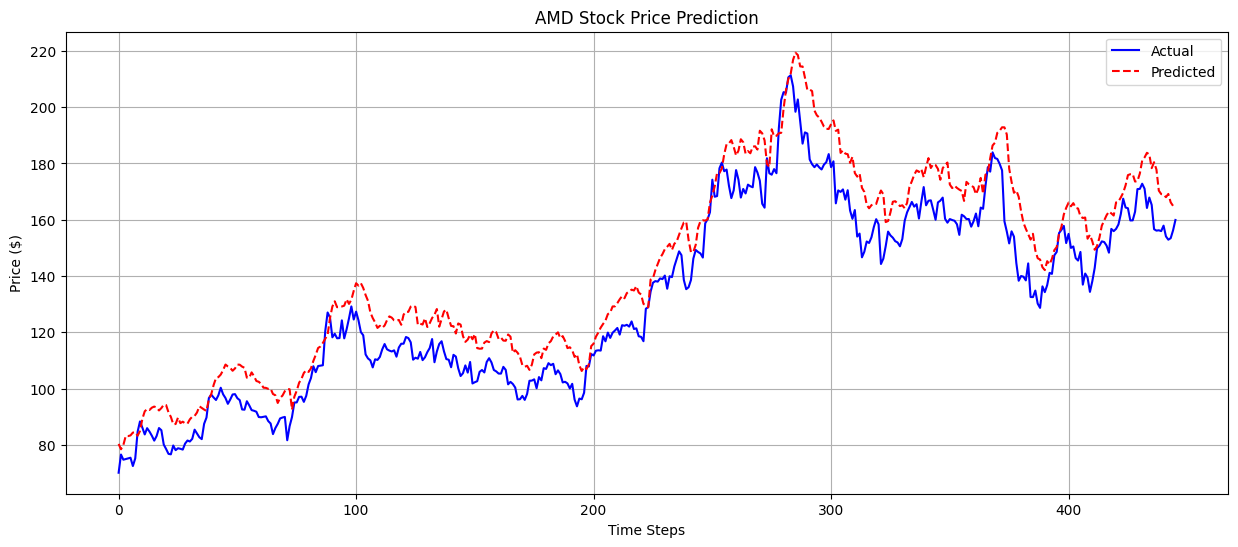


Analyzing CRM...

Evaluation Metrics for CRM:
MSE: 159.1311
RMSE: 12.6147
MAE:  11.0967


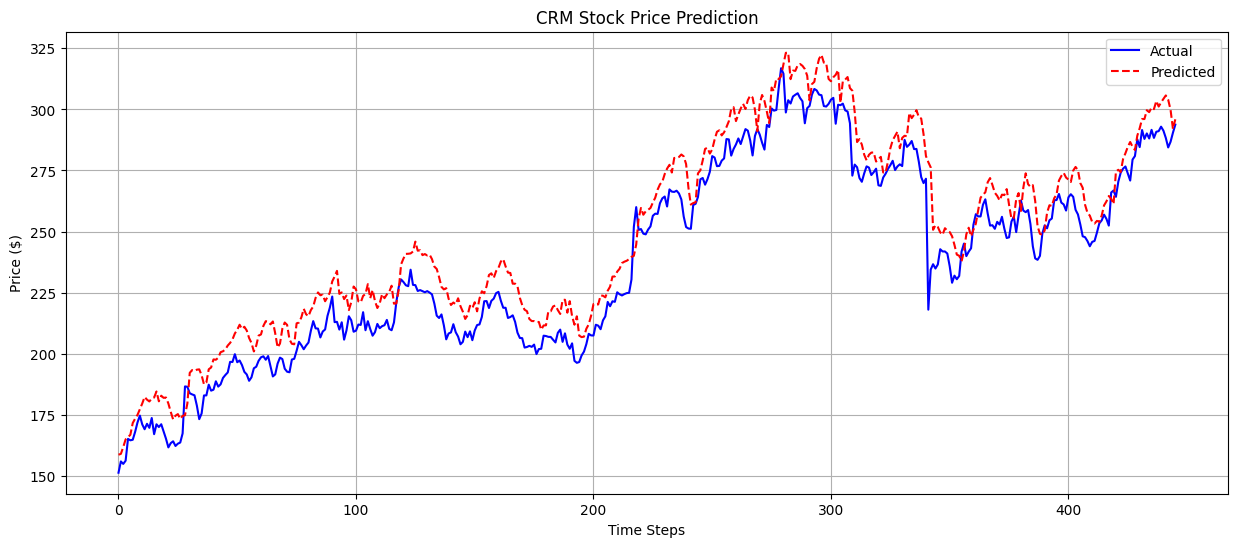


Analyzing JPM...

Evaluation Metrics for JPM:
MSE: 162.5401
RMSE: 12.7491
MAE:  12.3118


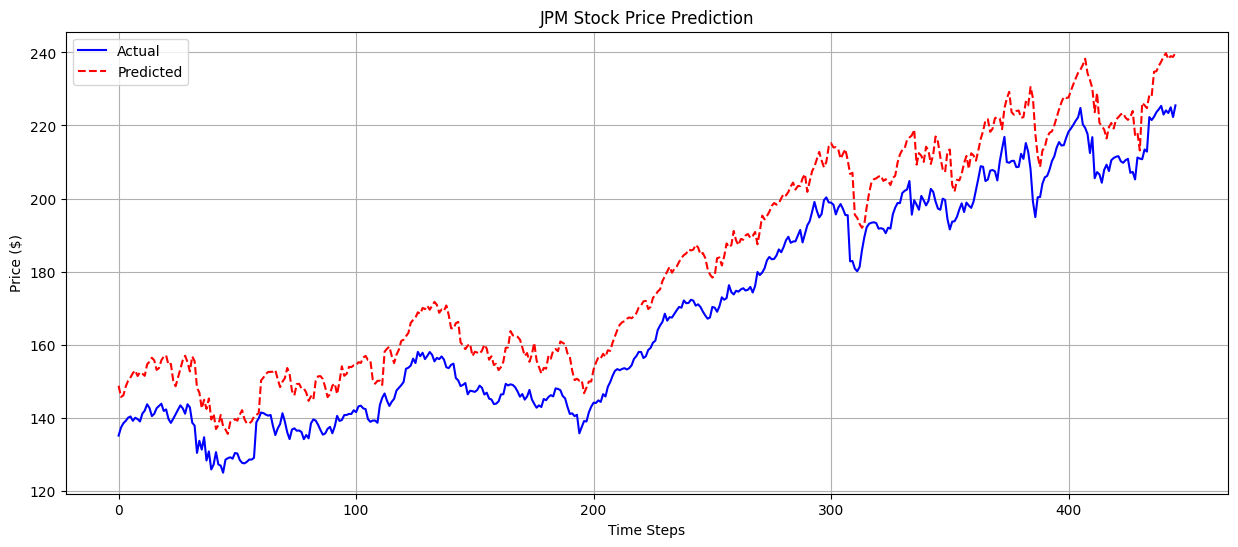


Analyzing V...

Evaluation Metrics for V:
MSE: 141.1688
RMSE: 11.8814
MAE:  10.9246


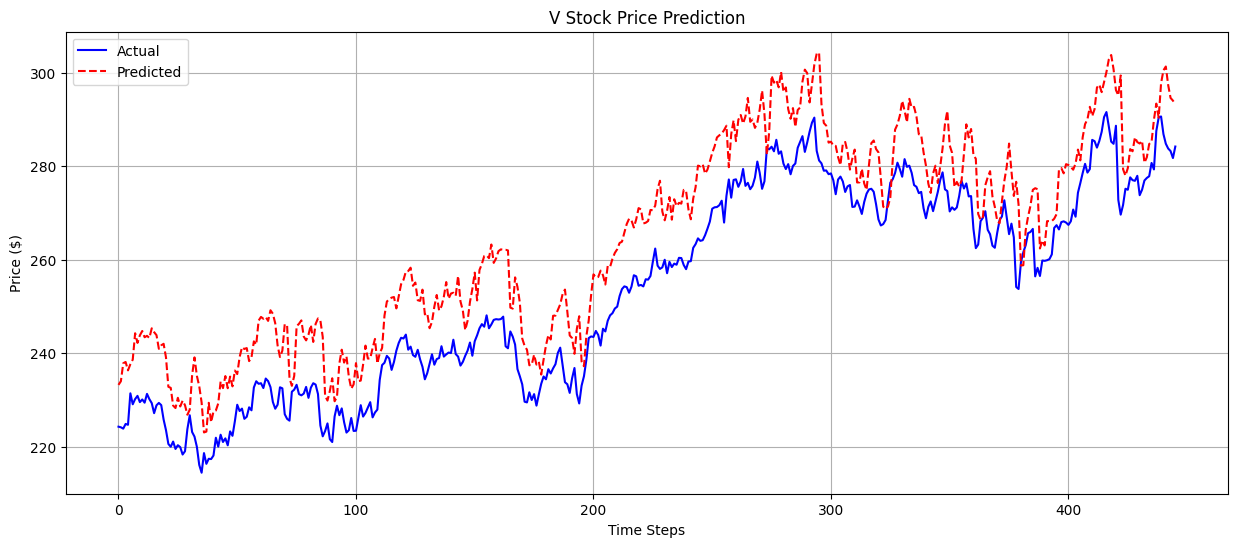


Analyzing MA...

Evaluation Metrics for MA:
MSE: 64.9259
RMSE: 8.0577
MAE:  6.3141


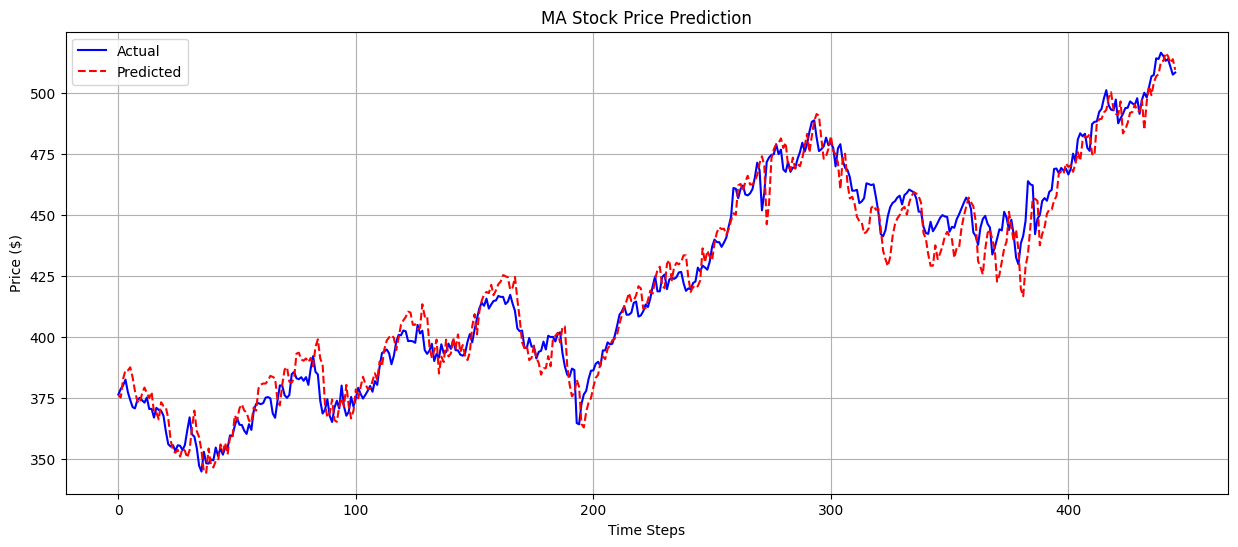


Analyzing MSTR...

Evaluation Metrics for MSTR:
MSE: 150.8661
RMSE: 12.2828
MAE:  9.9517


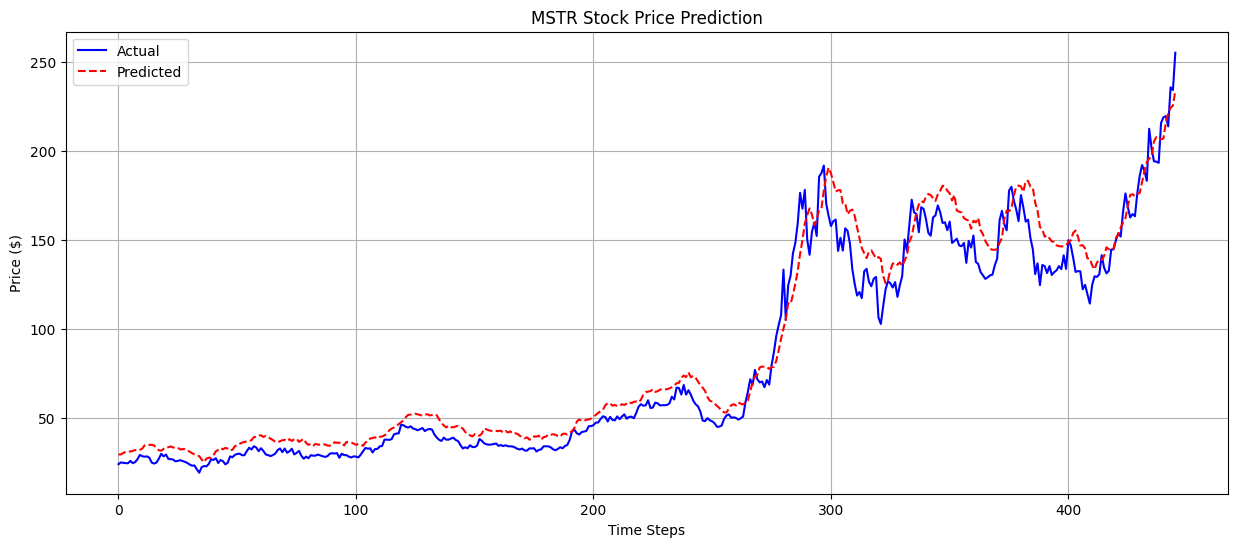


Analyzing DIS...

Evaluation Metrics for DIS:
MSE: 116.3898
RMSE: 10.7884
MAE:  10.4884


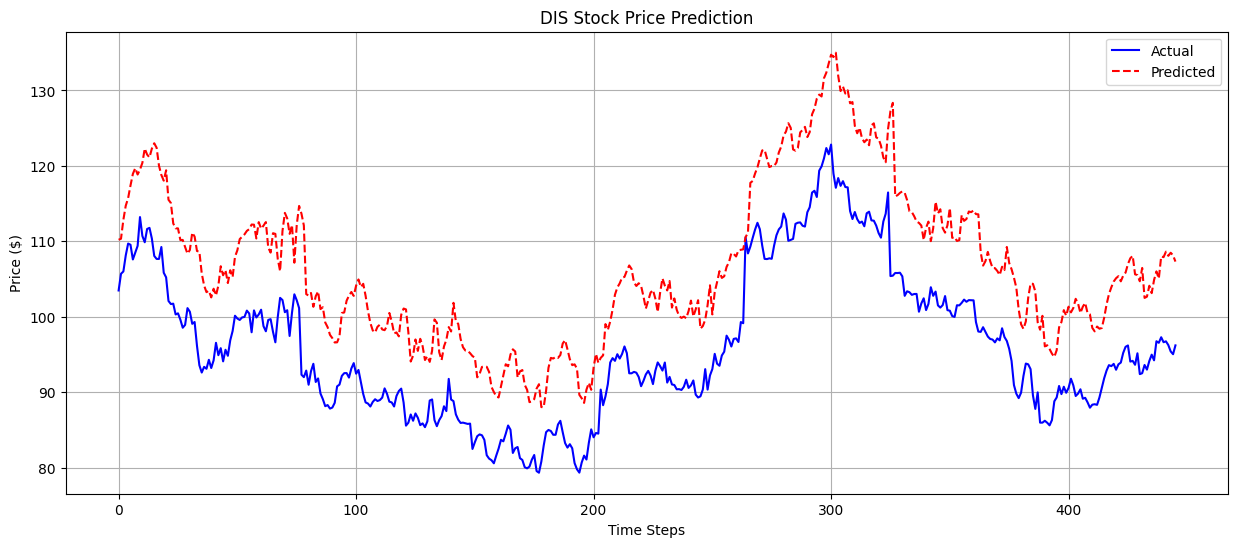


Analyzing BA...

Evaluation Metrics for BA:
MSE: 168.2454
RMSE: 12.9709
MAE:  11.7041


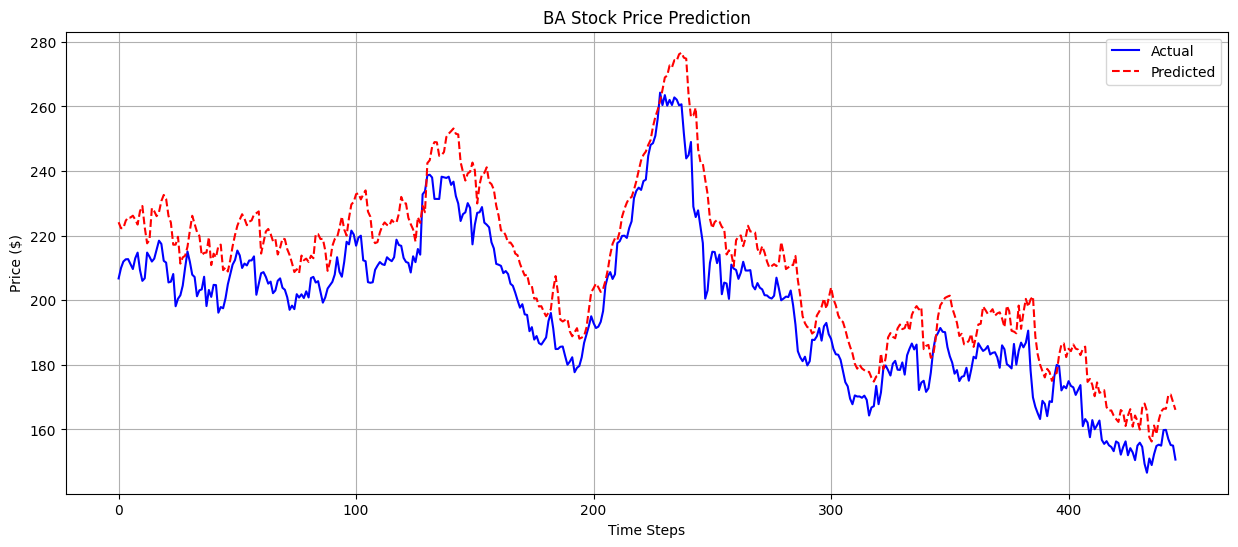


Analyzing XOM...

Evaluation Metrics for XOM:
MSE: 128.2288
RMSE: 11.3238
MAE:  11.0461


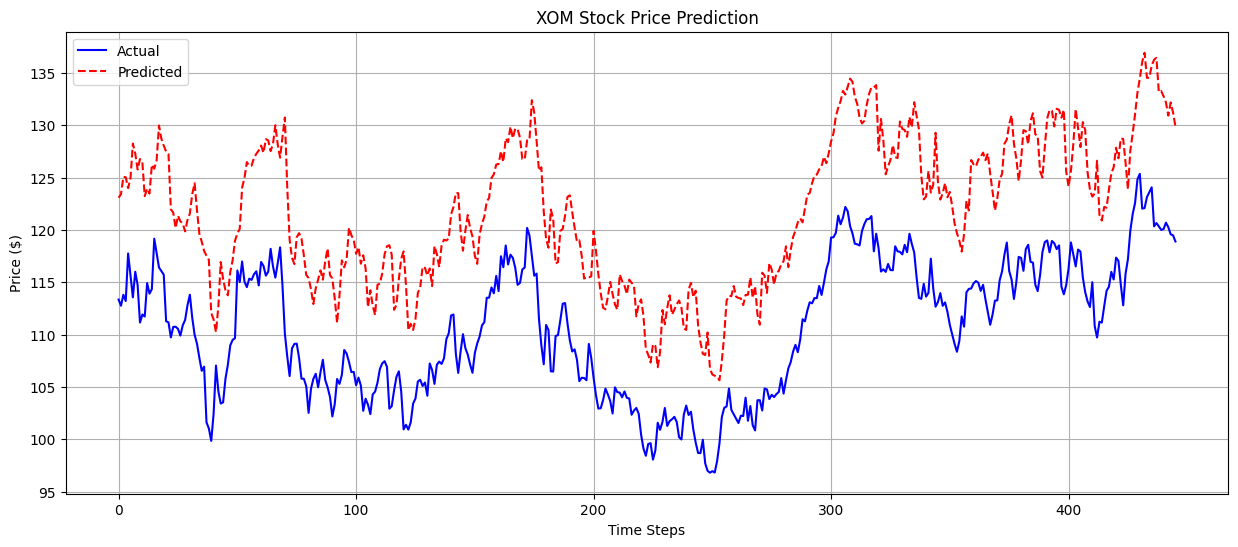


Analyzing ORCL...

Evaluation Metrics for ORCL:
MSE: 140.9678
RMSE: 11.8730
MAE:  11.3982


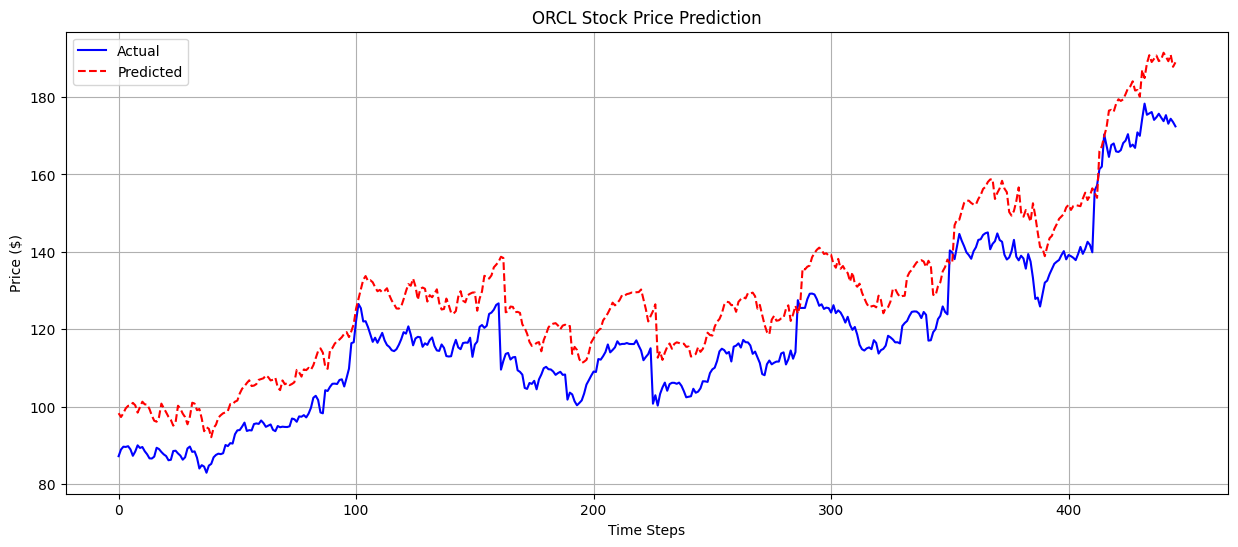


Analyzing META...

Evaluation Metrics for META:
MSE: 202.2172
RMSE: 14.2203
MAE:  11.3477


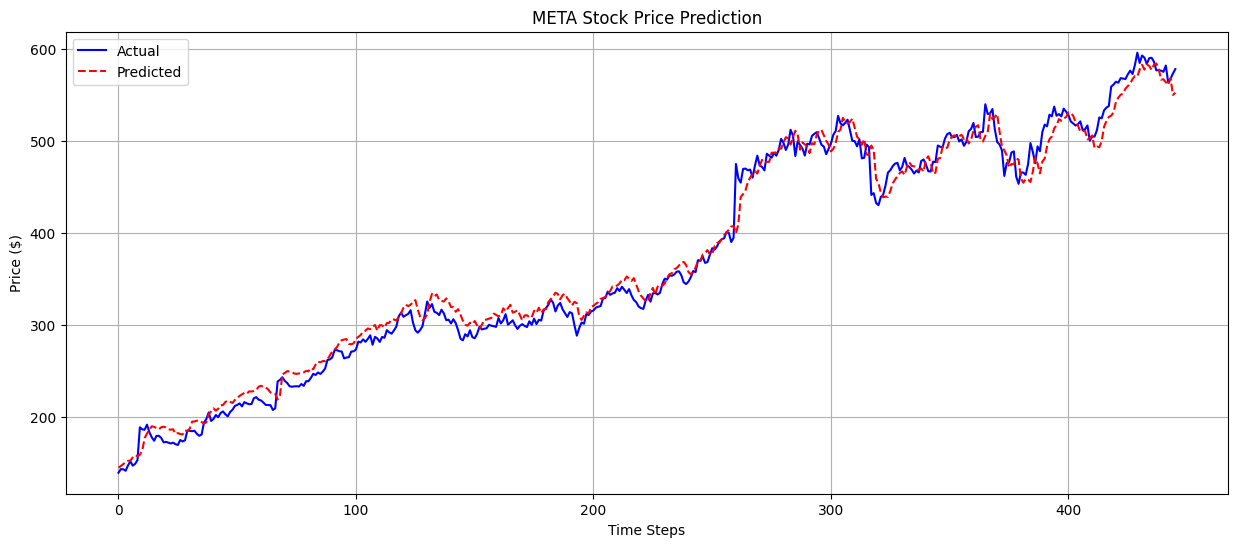


Summary of Metrics for All Stocks:
              MSE       RMSE        MAE
AAPL   155.690922  12.477617  11.855595
AMZN   158.288001  12.581256  11.927132
GME     36.862971   6.071488   5.720532
GOOGL  155.820045  12.482790  11.917660
NFLX   428.713672  20.705402  15.569560
TSLA   205.486571  14.334803  11.798588
MSFT    77.766668   8.818541   7.097421
NVDA    65.174347   8.073063   7.027311
AMD    157.381761  12.545189  11.088376
CRM    159.131134  12.614719  11.096689
JPM    162.540081  12.749121  12.311768
V      141.168767  11.881446  10.924632
MA      64.925928   8.057663   6.314079
MSTR   150.866150  12.282758   9.951664
DIS    116.389791  10.788410  10.488419
BA     168.245385  12.970944  11.704115
XOM    128.228808  11.323816  11.046055
ORCL   140.967756  11.872984  11.398200
META   202.217153  14.220308  11.347699
time: 9.4 s (started: 2024-11-18 08:00:17 +00:00)


In [19]:
tickers = ['AAPL', 'AMZN', 'GME', 'GOOGL', 'NFLX', 'TSLA', 'MSFT', 'NVDA', 'AMD', 'CRM', 'JPM', 'V', 'MA', 'MSTR', 'DIS', 'BA', 'XOM', 'ORCL', 'META']

def inverse_transform_price(scaled_data, scaler):
    """
    Convert scaled prices back to actual prices
    """
    # Create a dummy array with zeros for all features
    dummy = np.zeros((len(scaled_data), scaler.scale_.shape[0]))
    # Put the scaled prices in the correct column (-1 is close price next day )
    dummy[:, -1] = scaled_data
    # Inverse transform
    inverse_transformed = scaler.inverse_transform(dummy)
    # Return only the close price column
    return inverse_transformed[:, -1]

def evaluate_predictions(y_true, y_pred, ticker, scaler):
    """
    Calculate and print evaluation metrics for the predictions
    """
    # Convert scaled values back to actual prices
    y_true_actual = inverse_transform_price(y_true, scaler)
    y_pred_actual = inverse_transform_price(y_pred, scaler)
    
    # Calculate metrics on actual prices
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    
    print(f"\nEvaluation Metrics for {ticker}:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae: .4f}")
    
    return mse, rmse, mae

def plot_predictions(actual_values, predicted_values, ticker, scaler):
    """
    Plot actual vs predicted values in actual prices
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    actual_prices = inverse_transform_price(actual_values, scaler)
    predicted_prices = inverse_transform_price(predicted_values, scaler)
    
    # Create time axis for plotting
    time_steps = range(len(actual_prices))
    
    # Plot
    plt.plot(time_steps, actual_prices, label='Actual', color='blue')
    plt.plot(time_steps, predicted_prices, label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Make predictions for each stock
predictions_dict = {}
metrics_dict = {}

# Valid set predictions and evaluation
for i, ticker in enumerate(tickers):
    print(f"\nAnalyzing {ticker}...")
    
    # Get predictions for valid set
    val_predictions = model.predict(val_X_list[i], verbose=0)
    
    # Store predictions
    predictions_dict[ticker] = {'actual': val_y_list[i],'predicted': val_predictions}
    
    # Calculate metrics
    mse, rmse, mae = evaluate_predictions(val_y_list[i][:, 0], val_predictions[:, 0], ticker, global_scaler)
    metrics_dict[ticker] = {'MSE': mse,'RMSE': rmse, 'MAE': mae}
    
    # Plot val predictions
    plot_predictions(
        val_y_list[i][:, 0], 
        val_predictions[:, 0], 
        ticker,
        global_scaler
    )

# Create a summary DataFrame of metrics
metrics_df = pd.DataFrame(metrics_dict).T
print("\nSummary of Metrics for All Stocks:")
print(metrics_df)


Making Future Predictions...

Predicting future prices for AAPL...

AAPL - Next 5 days price predictions:
Day 1: $243.48
Day 2: $233.09
Day 3: $239.03
Day 4: $238.83
Day 5: $240.62
Day 6: $230.97
Day 7: $217.63
Day 8: $224.41
Day 9: $220.70
Day 10: $226.51
Day 11: $225.88
Day 12: $208.93
Day 13: $217.72
Day 14: $213.51
Day 15: $220.38
Day 16: $221.68
Day 17: $202.90
Day 18: $212.29
Day 19: $207.78
Day 20: $214.60
Day 21: $217.91
Day 22: $198.27
Day 23: $207.66
Day 24: $203.08
Day 25: $209.46

AAPL - Actual prices for comparison:
Day 1: $235.86
Day 2: $230.76
Day 3: $230.57
Day 4: $231.41
Day 5: $233.40
Day 6: $230.76
Day 7: $230.57
Day 8: $231.41
Day 9: $233.40
Day 10: $233.67
Day 11: $230.57
Day 12: $231.41
Day 13: $233.40
Day 14: $233.67
Day 15: $230.10
Day 16: $231.41
Day 17: $233.40
Day 18: $233.67
Day 19: $230.10
Day 20: $225.91
Day 21: $233.40
Day 22: $233.67
Day 23: $230.10
Day 24: $225.91
Day 25: $225.91


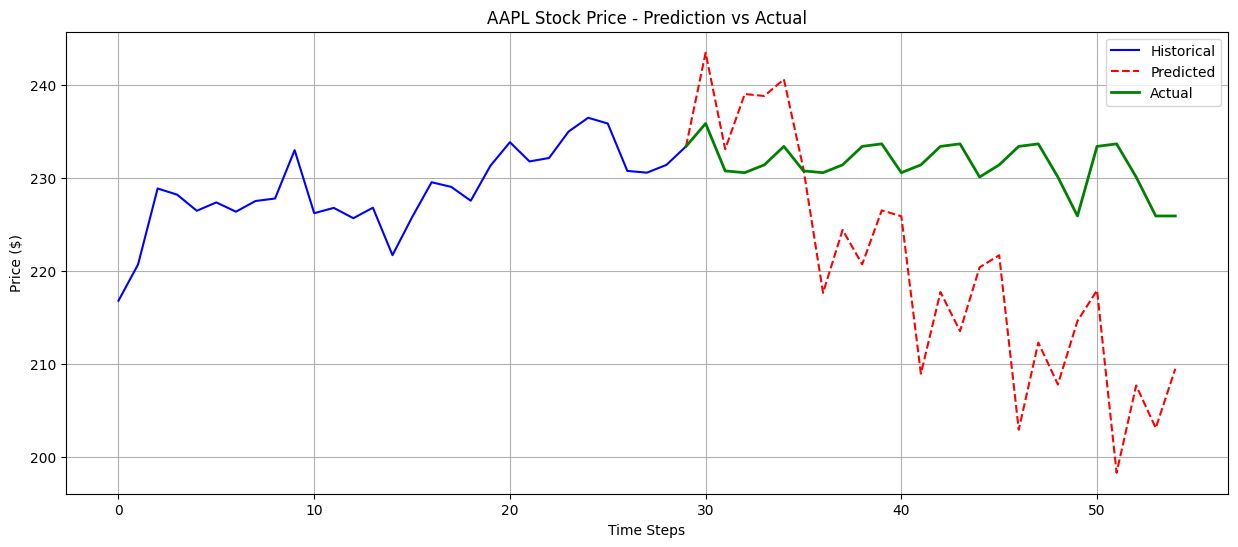


Predicting future prices for AMZN...

AMZN - Next 5 days price predictions:
Day 1: $198.93
Day 2: $188.44
Day 3: $194.20
Day 4: $194.74
Day 5: $195.87
Day 6: $189.78
Day 7: $174.13
Day 8: $183.33
Day 9: $179.33
Day 10: $185.83
Day 11: $187.02
Day 12: $167.00
Day 13: $179.08
Day 14: $173.87
Day 15: $182.11
Day 16: $184.83
Day 17: $162.92
Day 18: $175.61
Day 19: $170.16
Day 20: $178.63
Day 21: $182.85
Day 22: $160.40
Day 23: $172.74
Day 24: $167.54
Day 25: $175.58

AMZN - Actual prices for comparison:
Day 1: $189.70
Day 2: $184.71
Day 3: $186.38
Day 4: $187.83
Day 5: $188.39
Day 6: $184.71
Day 7: $186.38
Day 8: $187.83
Day 9: $188.39
Day 10: $190.83
Day 11: $186.38
Day 12: $187.83
Day 13: $188.39
Day 14: $190.83
Day 15: $192.73
Day 16: $187.83
Day 17: $188.39
Day 18: $190.83
Day 19: $192.73
Day 20: $186.40
Day 21: $188.39
Day 22: $190.83
Day 23: $192.73
Day 24: $186.40
Day 25: $186.40


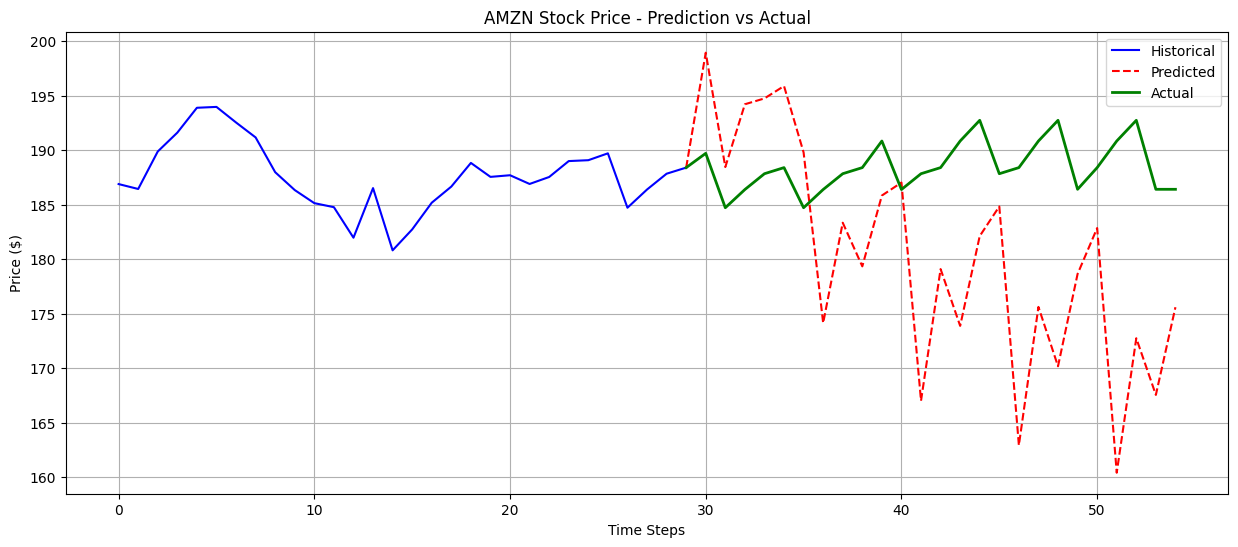


Predicting future prices for GME...

GME - Next 5 days price predictions:
Day 1: $26.43
Day 2: $19.75
Day 3: $24.35
Day 4: $23.43
Day 5: $23.73
Day 6: $25.94
Day 7: $6.11
Day 8: $23.07
Day 9: $12.77
Day 10: $22.59
Day 11: $27.13
Day 12: $0.54
Day 13: $22.91
Day 14: $9.97
Day 15: $22.26
Day 16: $28.44
Day 17: $-0.80
Day 18: $22.50
Day 19: $9.98
Day 20: $22.72
Day 21: $29.86
Day 22: $0.22
Day 23: $22.46
Day 24: $11.44
Day 25: $23.72

GME - Actual prices for comparison:
Day 1: $20.93
Day 2: $20.54
Day 3: $20.63
Day 4: $20.57
Day 5: $22.73
Day 6: $20.54
Day 7: $20.63
Day 8: $20.57
Day 9: $22.73
Day 10: $22.68
Day 11: $20.63
Day 12: $20.57
Day 13: $22.73
Day 14: $22.68
Day 15: $23.28
Day 16: $20.57
Day 17: $22.73
Day 18: $22.68
Day 19: $23.28
Day 20: $22.18
Day 21: $22.73
Day 22: $22.68
Day 23: $23.28
Day 24: $22.18
Day 25: $22.18


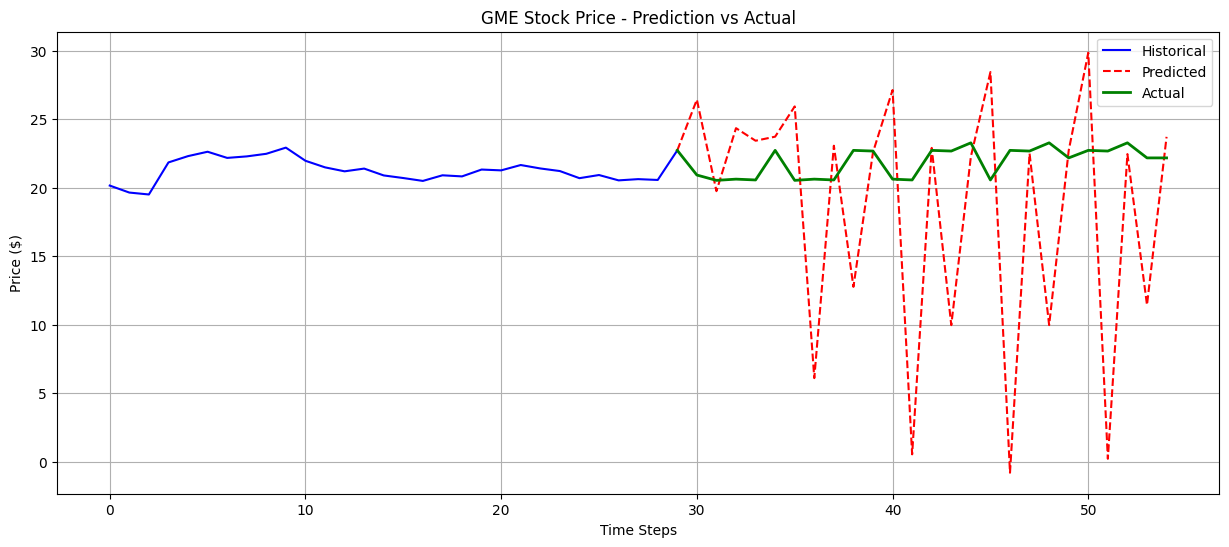


Predicting future prices for GOOGL...

GOOGL - Next 5 days price predictions:
Day 1: $174.01
Day 2: $164.11
Day 3: $170.55
Day 4: $170.21
Day 5: $171.22
Day 6: $168.45
Day 7: $151.09
Day 8: $162.73
Day 9: $157.34
Day 10: $164.56
Day 11: $167.00
Day 12: $145.10
Day 13: $159.34
Day 14: $152.95
Day 15: $162.15
Day 16: $165.88
Day 17: $142.13
Day 18: $156.63
Day 19: $150.41
Day 20: $159.92
Day 21: $164.86
Day 22: $140.76
Day 23: $154.56
Day 24: $148.93
Day 25: $157.97

GOOGL - Actual prices for comparison:
Day 1: $165.14
Day 2: $162.78
Day 3: $162.72
Day 4: $165.27
Day 5: $166.72
Day 6: $162.78
Day 7: $162.72
Day 8: $165.27
Day 9: $166.72
Day 10: $169.68
Day 11: $162.72
Day 12: $165.27
Day 13: $166.72
Day 14: $169.68
Day 15: $174.46
Day 16: $165.27
Day 17: $166.72
Day 18: $169.68
Day 19: $174.46
Day 20: $171.11
Day 21: $166.72
Day 22: $169.68
Day 23: $174.46
Day 24: $171.11
Day 25: $171.11


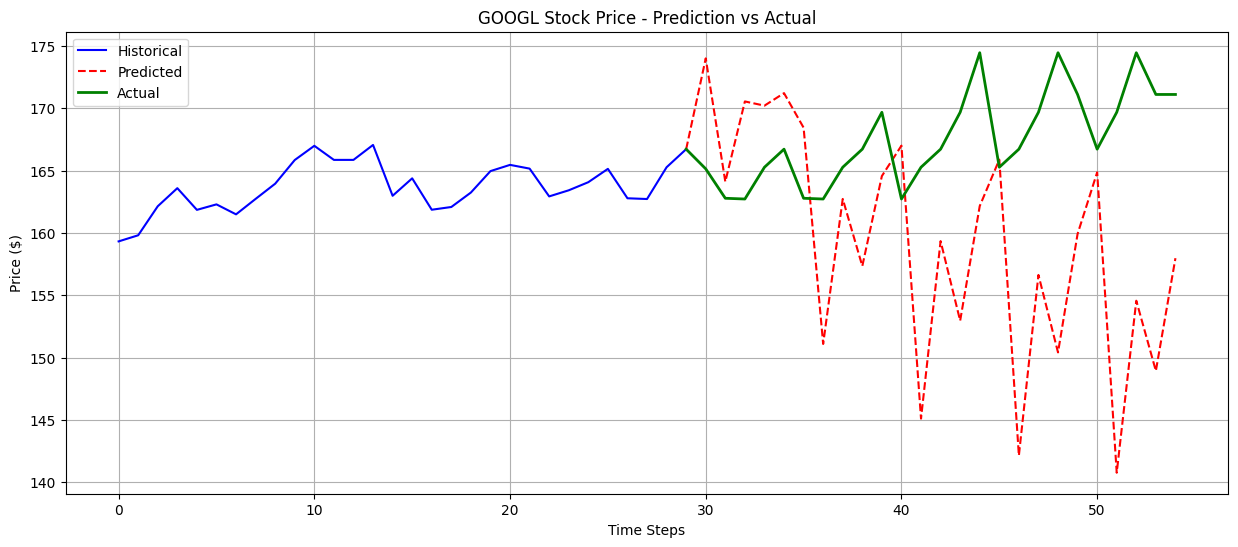


Predicting future prices for NFLX...

NFLX - Next 5 days price predictions:
Day 1: $718.75
Day 2: $707.10
Day 3: $680.35
Day 4: $669.43
Day 5: $684.28
Day 6: $662.18
Day 7: $676.82
Day 8: $600.78
Day 9: $621.37
Day 10: $596.95
Day 11: $627.51
Day 12: $647.50
Day 13: $558.43
Day 14: $598.81
Day 15: $555.64
Day 16: $598.19
Day 17: $618.71
Day 18: $527.14
Day 19: $572.95
Day 20: $523.33
Day 21: $572.07
Day 22: $589.76
Day 23: $502.08
Day 24: $546.76
Day 25: $497.21

NFLX - Actual prices for comparison:
Day 1: $764.24
Day 2: $749.29
Day 3: $754.55
Day 4: $754.68
Day 5: $749.12
Day 6: $749.29
Day 7: $754.55
Day 8: $754.68
Day 9: $749.12
Day 10: $759.44
Day 11: $754.55
Day 12: $754.68
Day 13: $749.12
Day 14: $759.44
Day 15: $753.74
Day 16: $754.68
Day 17: $749.12
Day 18: $759.44
Day 19: $753.74
Day 20: $756.03
Day 21: $749.12
Day 22: $759.44
Day 23: $753.74
Day 24: $756.03
Day 25: $756.03


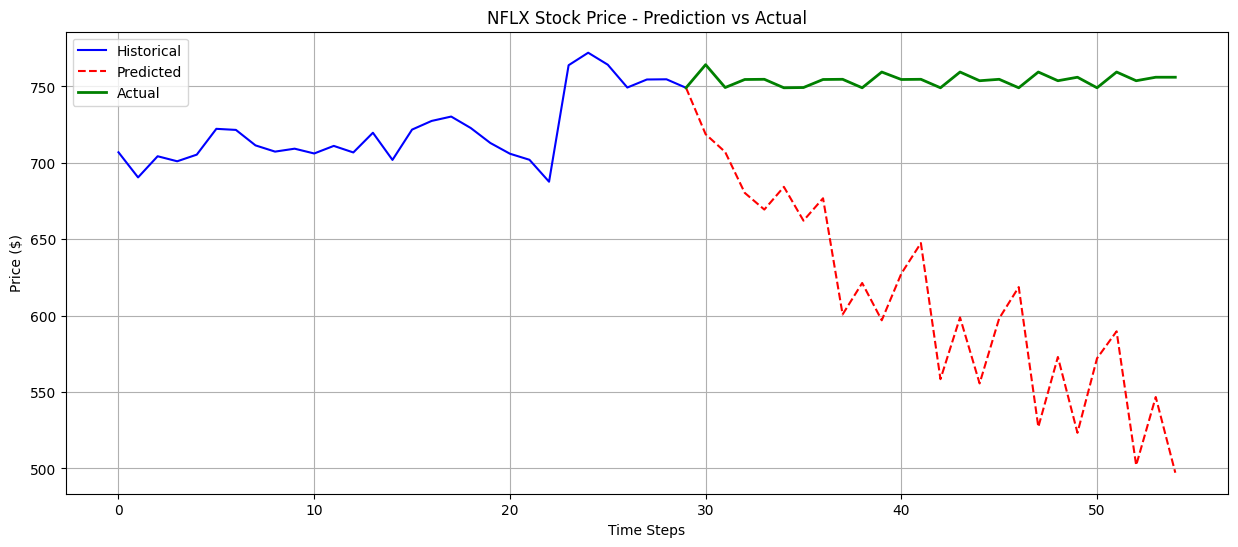


Predicting future prices for TSLA...

TSLA - Next 5 days price predictions:
Day 1: $254.56
Day 2: $240.94
Day 3: $243.53
Day 4: $244.10
Day 5: $243.73
Day 6: $237.66
Day 7: $225.05
Day 8: $226.68
Day 9: $226.75
Day 10: $229.07
Day 11: $233.15
Day 12: $216.54
Day 13: $222.11
Day 14: $220.23
Day 15: $224.59
Day 16: $229.27
Day 17: $210.81
Day 18: $218.07
Day 19: $215.15
Day 20: $219.78
Day 21: $225.60
Day 22: $206.30
Day 23: $214.23
Day 24: $210.81
Day 25: $215.13

TSLA - Actual prices for comparison:
Day 1: $217.97
Day 2: $213.65
Day 3: $260.48
Day 4: $269.19
Day 5: $262.51
Day 6: $213.65
Day 7: $260.48
Day 8: $269.19
Day 9: $262.51
Day 10: $259.52
Day 11: $260.48
Day 12: $269.19
Day 13: $262.51
Day 14: $259.52
Day 15: $257.55
Day 16: $269.19
Day 17: $262.51
Day 18: $259.52
Day 19: $257.55
Day 20: $249.85
Day 21: $262.51
Day 22: $259.52
Day 23: $257.55
Day 24: $249.85
Day 25: $249.85


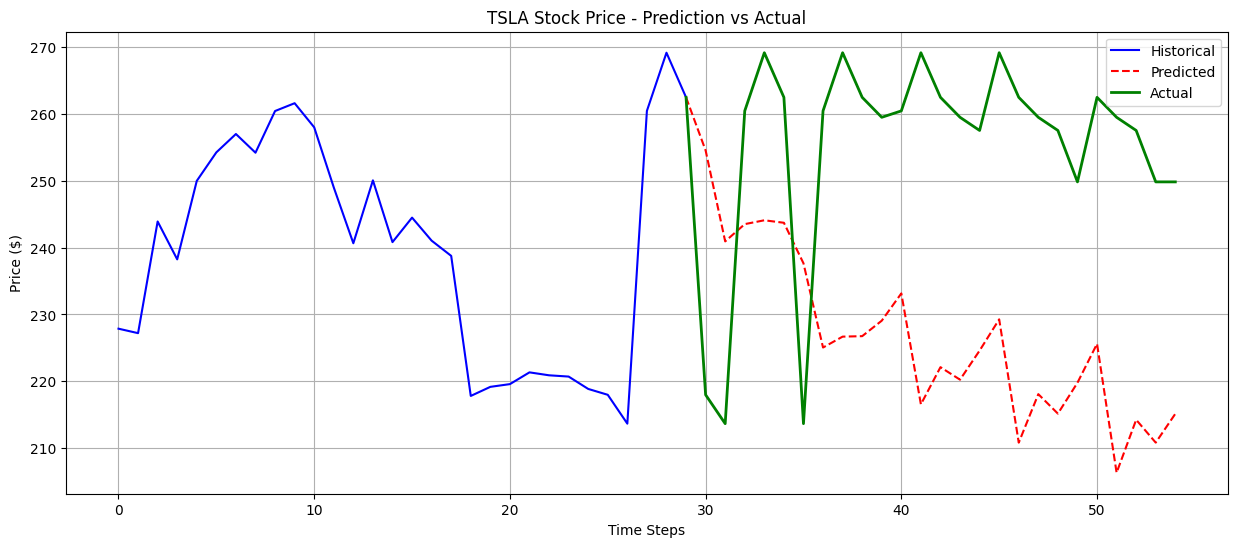


Predicting future prices for MSFT...

MSFT - Next 5 days price predictions:
Day 1: $424.59
Day 2: $421.02
Day 3: $418.85
Day 4: $418.52
Day 5: $424.27
Day 6: $394.59
Day 7: $396.16
Day 8: $384.19
Day 9: $382.95
Day 10: $383.90
Day 11: $378.39
Day 12: $377.84
Day 13: $365.67
Day 14: $366.14
Day 15: $364.49
Day 16: $364.14
Day 17: $361.27
Day 18: $350.09
Day 19: $350.74
Day 20: $347.30
Day 21: $351.29
Day 22: $345.73
Day 23: $336.38
Day 24: $336.59
Day 25: $332.30

MSFT - Actual prices for comparison:
Day 1: $427.51
Day 2: $424.60
Day 3: $424.73
Day 4: $428.15
Day 5: $426.59
Day 6: $424.60
Day 7: $424.73
Day 8: $428.15
Day 9: $426.59
Day 10: $431.95
Day 11: $424.73
Day 12: $428.15
Day 13: $426.59
Day 14: $431.95
Day 15: $432.53
Day 16: $428.15
Day 17: $426.59
Day 18: $431.95
Day 19: $432.53
Day 20: $406.35
Day 21: $426.59
Day 22: $431.95
Day 23: $432.53
Day 24: $406.35
Day 25: $406.35


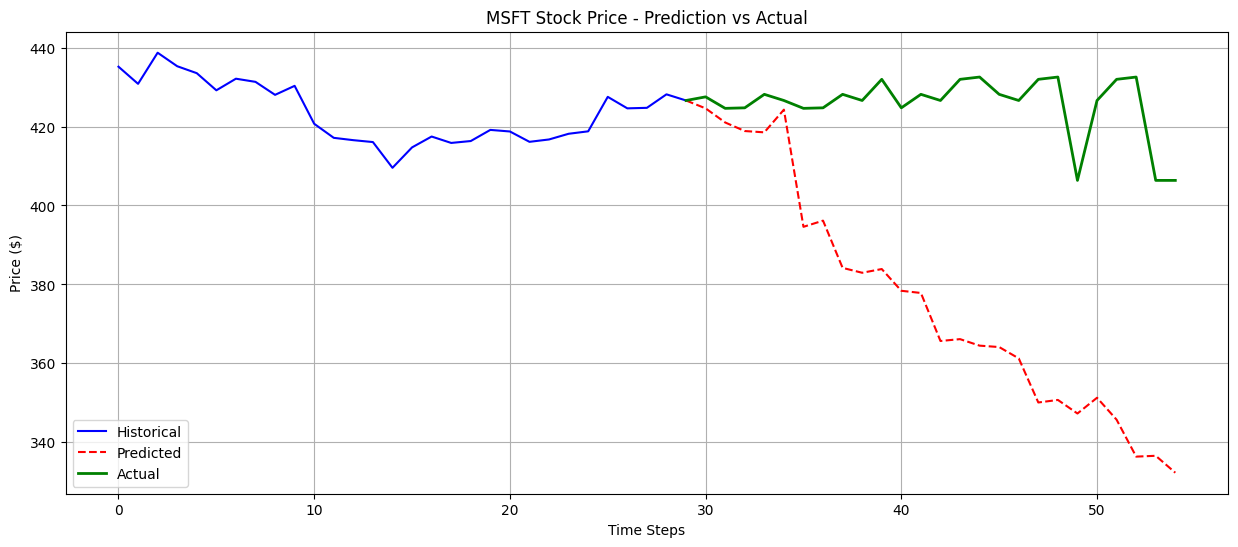


Predicting future prices for NVDA...

NVDA - Next 5 days price predictions:
Day 1: $152.45
Day 2: $141.51
Day 3: $145.11
Day 4: $147.74
Day 5: $146.31
Day 6: $143.00
Day 7: $126.16
Day 8: $135.72
Day 9: $132.17
Day 10: $138.75
Day 11: $140.66
Day 12: $119.14
Day 13: $132.79
Day 14: $128.12
Day 15: $136.55
Day 16: $139.28
Day 17: $115.74
Day 18: $130.56
Day 19: $125.56
Day 20: $134.45
Day 21: $138.35
Day 22: $114.29
Day 23: $128.97
Day 24: $124.00
Day 25: $132.78

NVDA - Actual prices for comparison:
Day 1: $143.59
Day 2: $139.56
Day 3: $140.41
Day 4: $141.54
Day 5: $140.52
Day 6: $139.56
Day 7: $140.41
Day 8: $141.54
Day 9: $140.52
Day 10: $141.25
Day 11: $140.41
Day 12: $141.54
Day 13: $140.52
Day 14: $141.25
Day 15: $139.34
Day 16: $141.54
Day 17: $140.52
Day 18: $141.25
Day 19: $139.34
Day 20: $132.76
Day 21: $140.52
Day 22: $141.25
Day 23: $139.34
Day 24: $132.76
Day 25: $132.76


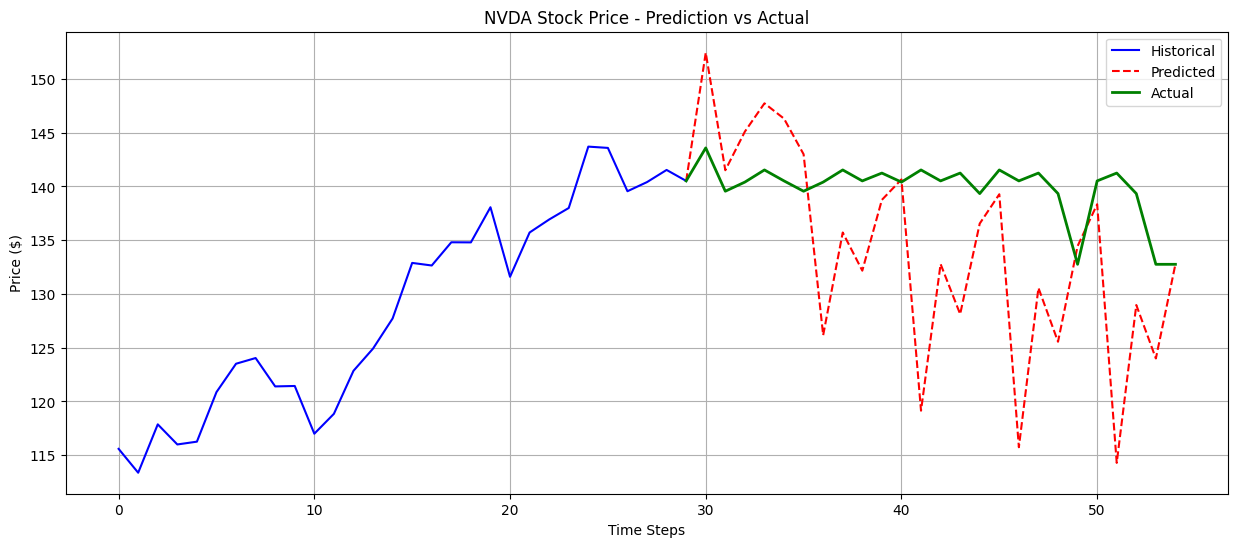


Predicting future prices for AMD...

AMD - Next 5 days price predictions:
Day 1: $165.24
Day 2: $155.33
Day 3: $160.61
Day 4: $160.29
Day 5: $159.94
Day 6: $162.71
Day 7: $144.61
Day 8: $155.34
Day 9: $150.96
Day 10: $156.89
Day 11: $162.23
Day 12: $139.57
Day 13: $153.10
Day 14: $147.63
Day 15: $155.86
Day 16: $161.89
Day 17: $137.37
Day 18: $151.39
Day 19: $146.01
Day 20: $154.69
Day 21: $161.47
Day 22: $136.71
Day 23: $150.11
Day 24: $145.33
Day 25: $153.55

AMD - Actual prices for comparison:
Day 1: $154.09
Day 2: $152.91
Day 3: $153.44
Day 4: $156.23
Day 5: $159.92
Day 6: $152.91
Day 7: $153.44
Day 8: $156.23
Day 9: $159.92
Day 10: $166.25
Day 11: $153.44
Day 12: $156.23
Day 13: $159.92
Day 14: $166.25
Day 15: $148.60
Day 16: $156.23
Day 17: $159.92
Day 18: $166.25
Day 19: $148.60
Day 20: $144.07
Day 21: $159.92
Day 22: $166.25
Day 23: $148.60
Day 24: $144.07
Day 25: $144.07


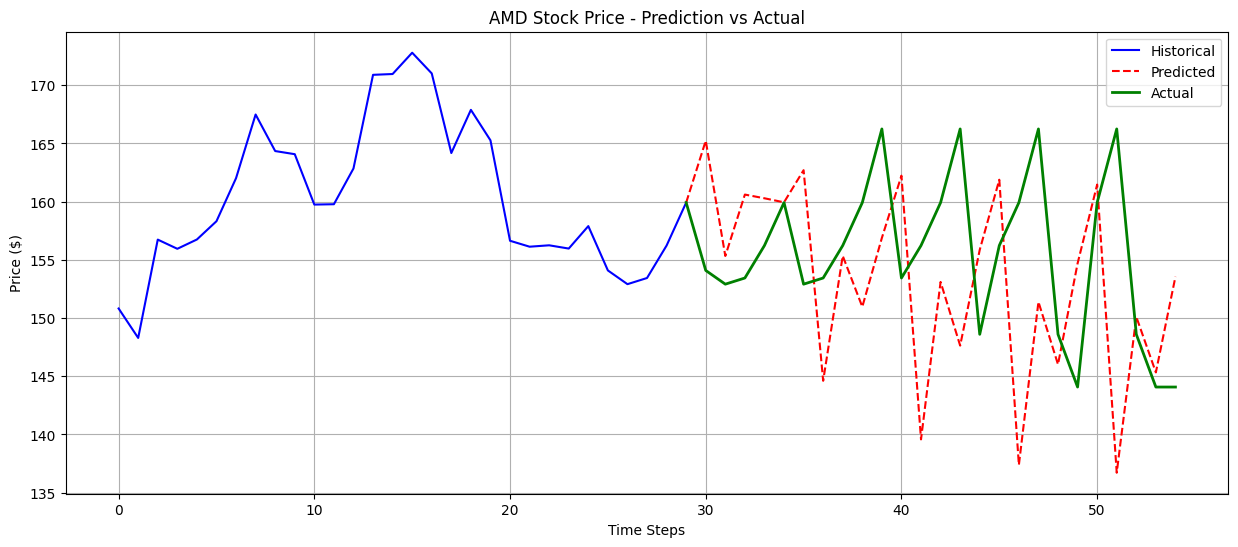


Predicting future prices for CRM...

CRM - Next 5 days price predictions:
Day 1: $295.95
Day 2: $286.69
Day 3: $290.19
Day 4: $291.20
Day 5: $293.89
Day 6: $280.41
Day 7: $269.99
Day 8: $272.83
Day 9: $270.40
Day 10: $275.03
Day 11: $272.19
Day 12: $258.91
Day 13: $262.90
Day 14: $260.72
Day 15: $265.53
Day 16: $265.16
Day 17: $250.00
Day 18: $254.69
Day 19: $252.25
Day 20: $256.66
Day 21: $258.88
Day 22: $242.41
Day 23: $247.66
Day 24: $244.81
Day 25: $248.70

CRM - Actual prices for comparison:
Day 1: $288.33
Day 2: $284.43
Day 3: $286.76
Day 4: $290.46
Day 5: $293.77
Day 6: $284.43
Day 7: $286.76
Day 8: $290.46
Day 9: $293.77
Day 10: $298.89
Day 11: $286.76
Day 12: $290.46
Day 13: $293.77
Day 14: $298.89
Day 15: $296.40
Day 16: $290.46
Day 17: $293.77
Day 18: $298.89
Day 19: $296.40
Day 20: $291.37
Day 21: $293.77
Day 22: $298.89
Day 23: $296.40
Day 24: $291.37
Day 25: $291.37


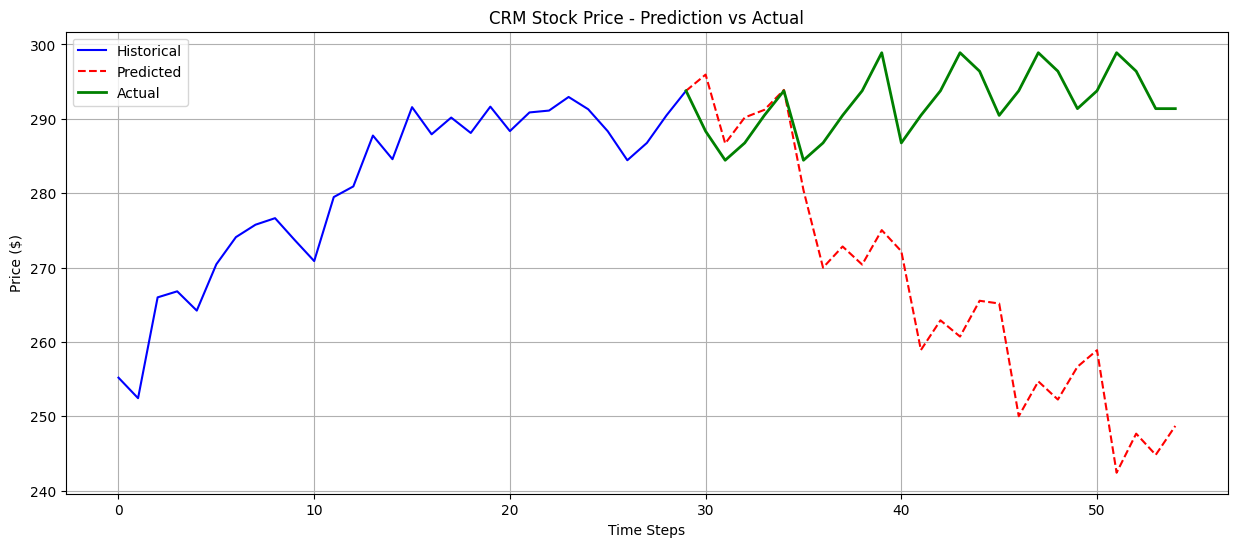


Predicting future prices for JPM...

JPM - Next 5 days price predictions:
Day 1: $239.92
Day 2: $228.58
Day 3: $234.81
Day 4: $233.91
Day 5: $235.30
Day 6: $224.11
Day 7: $210.63
Day 8: $217.19
Day 9: $212.09
Day 10: $219.13
Day 11: $218.80
Day 12: $201.41
Day 13: $210.41
Day 14: $205.34
Day 15: $213.39
Day 16: $214.69
Day 17: $195.36
Day 18: $205.07
Day 19: $199.95
Day 20: $207.80
Day 21: $211.10
Day 22: $190.89
Day 23: $200.60
Day 24: $195.58
Day 25: $202.85

JPM - Actual prices for comparison:
Day 1: $224.12
Day 2: $223.41
Day 3: $224.98
Day 4: $222.31
Day 5: $225.50
Day 6: $223.41
Day 7: $224.98
Day 8: $222.31
Day 9: $225.50
Day 10: $222.90
Day 11: $224.98
Day 12: $222.31
Day 13: $225.50
Day 14: $222.90
Day 15: $224.41
Day 16: $222.31
Day 17: $225.50
Day 18: $222.90
Day 19: $224.41
Day 20: $221.92
Day 21: $225.50
Day 22: $222.90
Day 23: $224.41
Day 24: $221.92
Day 25: $221.92


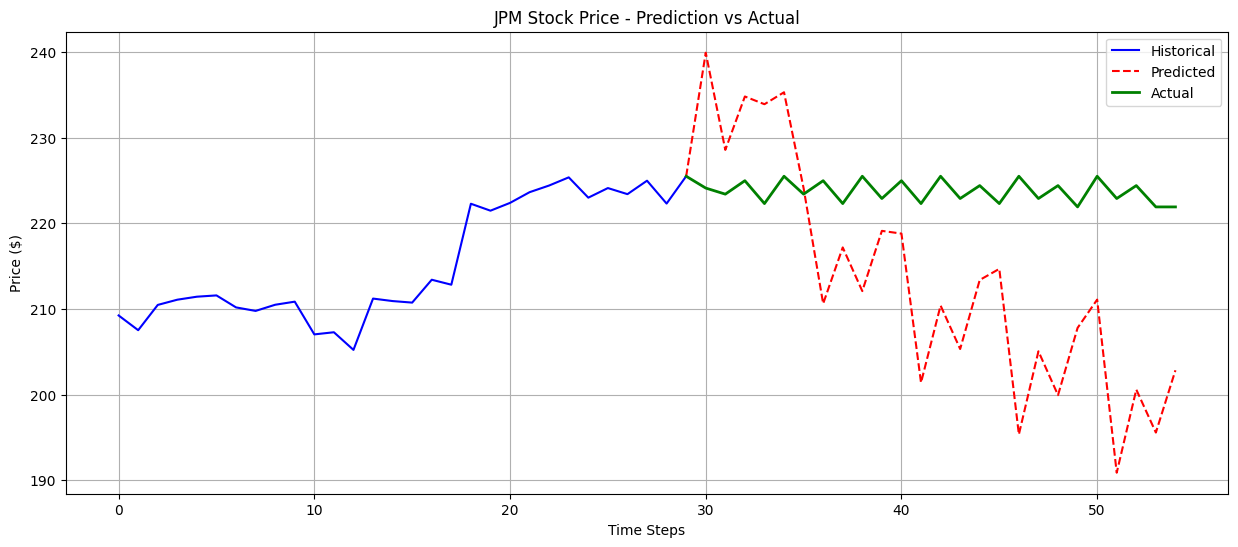


Predicting future prices for V...

V - Next 5 days price predictions:
Day 1: $293.20
Day 2: $283.47
Day 3: $288.44
Day 4: $288.34
Day 5: $290.40
Day 6: $277.03
Day 7: $266.10
Day 8: $269.75
Day 9: $265.81
Day 10: $270.72
Day 11: $269.62
Day 12: $255.50
Day 13: $260.42
Day 14: $256.21
Day 15: $261.69
Day 16: $263.18
Day 17: $247.27
Day 18: $252.63
Day 19: $248.24
Day 20: $253.36
Day 21: $257.29
Day 22: $240.27
Day 23: $245.85
Day 24: $241.43
Day 25: $245.94

V - Actual prices for comparison:
Day 1: $284.79
Day 2: $283.76
Day 3: $283.22
Day 4: $281.73
Day 5: $284.19
Day 6: $283.76
Day 7: $283.22
Day 8: $281.73
Day 9: $284.19
Day 10: $281.88
Day 11: $283.22
Day 12: $281.73
Day 13: $284.19
Day 14: $281.88
Day 15: $290.16
Day 16: $281.73
Day 17: $284.19
Day 18: $281.88
Day 19: $290.16
Day 20: $289.85
Day 21: $284.19
Day 22: $281.88
Day 23: $290.16
Day 24: $289.85
Day 25: $289.85


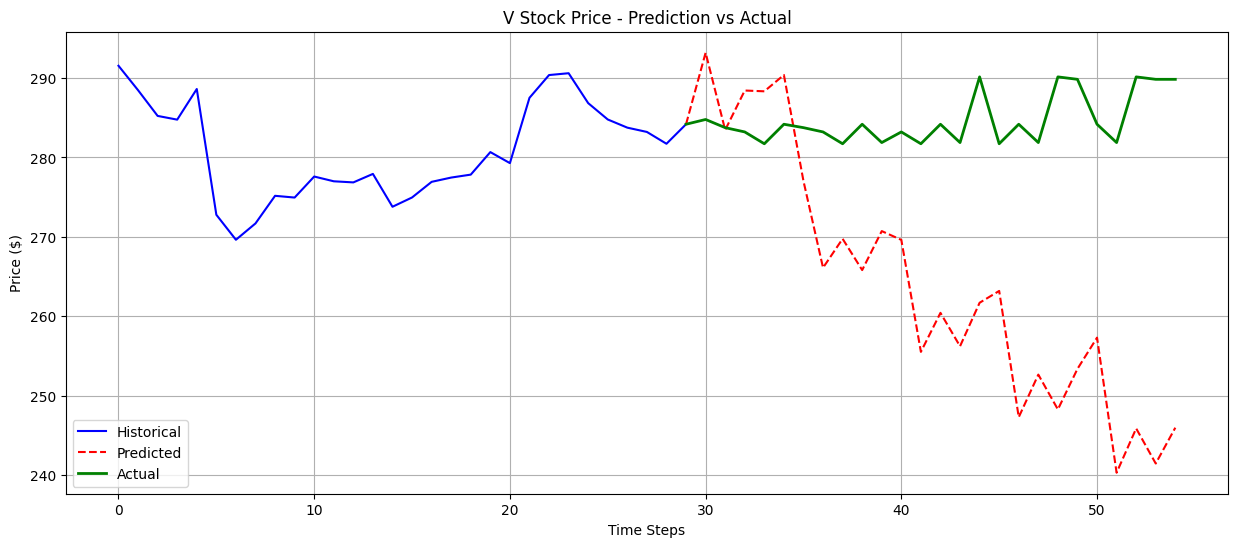


Predicting future prices for MA...

MA - Next 5 days price predictions:
Day 1: $509.32
Day 2: $503.73
Day 3: $497.16
Day 4: $494.55
Day 5: $500.70
Day 6: $471.84
Day 7: $476.73
Day 8: $451.27
Day 9: $453.45
Day 10: $448.91
Day 11: $449.51
Day 12: $454.71
Day 13: $425.42
Day 14: $434.28
Day 15: $423.52
Day 16: $430.08
Day 17: $433.85
Day 18: $404.78
Day 19: $415.10
Day 20: $401.65
Day 21: $412.73
Day 22: $413.68
Day 23: $387.29
Day 24: $396.75
Day 25: $382.88

MA - Actual prices for comparison:
Day 1: $513.02
Day 2: $513.73
Day 3: $510.62
Day 4: $507.36
Day 5: $508.21
Day 6: $513.73
Day 7: $510.62
Day 8: $507.36
Day 9: $508.21
Day 10: $506.28
Day 11: $510.62
Day 12: $507.36
Day 13: $508.21
Day 14: $506.28
Day 15: $513.69
Day 16: $507.36
Day 17: $508.21
Day 18: $506.28
Day 19: $513.69
Day 20: $499.59
Day 21: $508.21
Day 22: $506.28
Day 23: $513.69
Day 24: $499.59
Day 25: $499.59


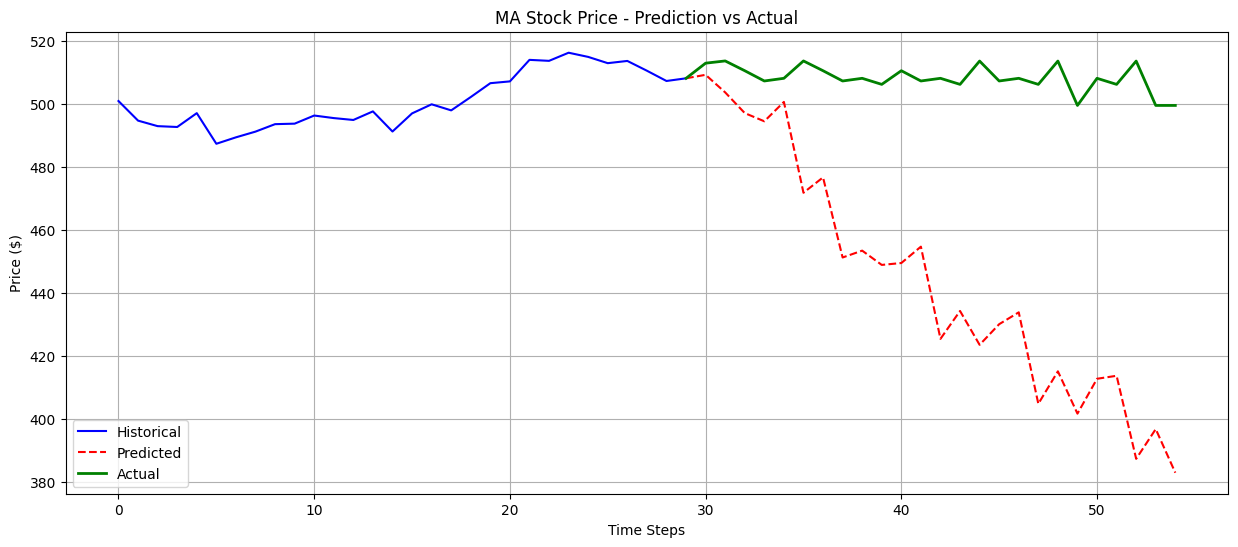


Predicting future prices for MSTR...

MSTR - Next 5 days price predictions:
Day 1: $234.13
Day 2: $221.40
Day 3: $223.20
Day 4: $228.14
Day 5: $223.50
Day 6: $216.51
Day 7: $202.70
Day 8: $205.82
Day 9: $207.82
Day 10: $209.61
Day 11: $210.57
Day 12: $192.62
Day 13: $199.87
Day 14: $201.34
Day 15: $205.00
Day 16: $206.24
Day 17: $186.25
Day 18: $195.27
Day 19: $195.66
Day 20: $199.90
Day 21: $202.67
Day 22: $181.79
Day 23: $191.42
Day 24: $190.84
Day 25: $195.22

MSTR - Actual prices for comparison:
Day 1: $219.70
Day 2: $213.95
Day 3: $235.89
Day 4: $234.34
Day 5: $255.34
Day 6: $213.95
Day 7: $235.89
Day 8: $234.34
Day 9: $255.34
Day 10: $258.24
Day 11: $235.89
Day 12: $234.34
Day 13: $255.34
Day 14: $258.24
Day 15: $247.31
Day 16: $234.34
Day 17: $255.34
Day 18: $258.24
Day 19: $247.31
Day 20: $244.50
Day 21: $255.34
Day 22: $258.24
Day 23: $247.31
Day 24: $244.50
Day 25: $244.50


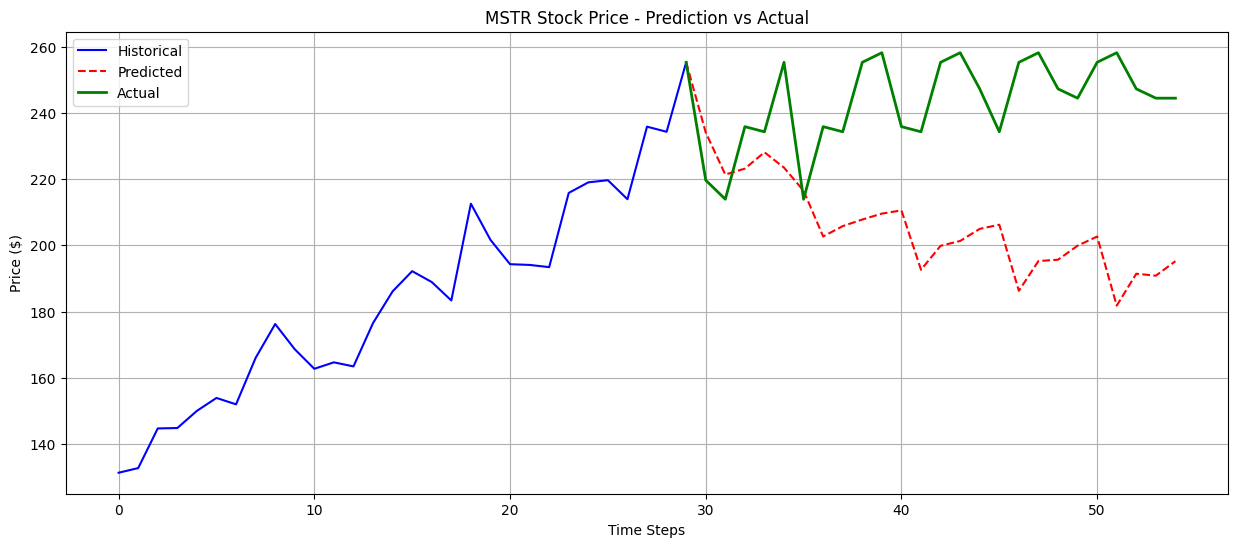


Predicting future prices for DIS...

DIS - Next 5 days price predictions:
Day 1: $107.31
Day 2: $97.39
Day 3: $102.38
Day 4: $102.61
Day 5: $102.56
Day 6: $102.20
Day 7: $83.28
Day 8: $96.81
Day 9: $89.50
Day 10: $98.26
Day 11: $102.16
Day 12: $77.75
Day 13: $95.58
Day 14: $86.59
Day 15: $97.48
Day 16: $102.59
Day 17: $76.00
Day 18: $94.61
Day 19: $85.68
Day 20: $97.12
Day 21: $103.09
Day 22: $76.27
Day 23: $94.01
Day 24: $85.96
Day 25: $97.17

DIS - Actual prices for comparison:
Day 1: $96.74
Day 2: $96.24
Day 3: $95.40
Day 4: $95.03
Day 5: $96.20
Day 6: $96.24
Day 7: $95.40
Day 8: $95.03
Day 9: $96.20
Day 10: $96.13
Day 11: $95.40
Day 12: $95.03
Day 13: $96.20
Day 14: $96.13
Day 15: $95.08
Day 16: $95.03
Day 17: $96.20
Day 18: $96.13
Day 19: $95.08
Day 20: $96.20
Day 21: $96.20
Day 22: $96.13
Day 23: $95.08
Day 24: $96.20
Day 25: $96.20


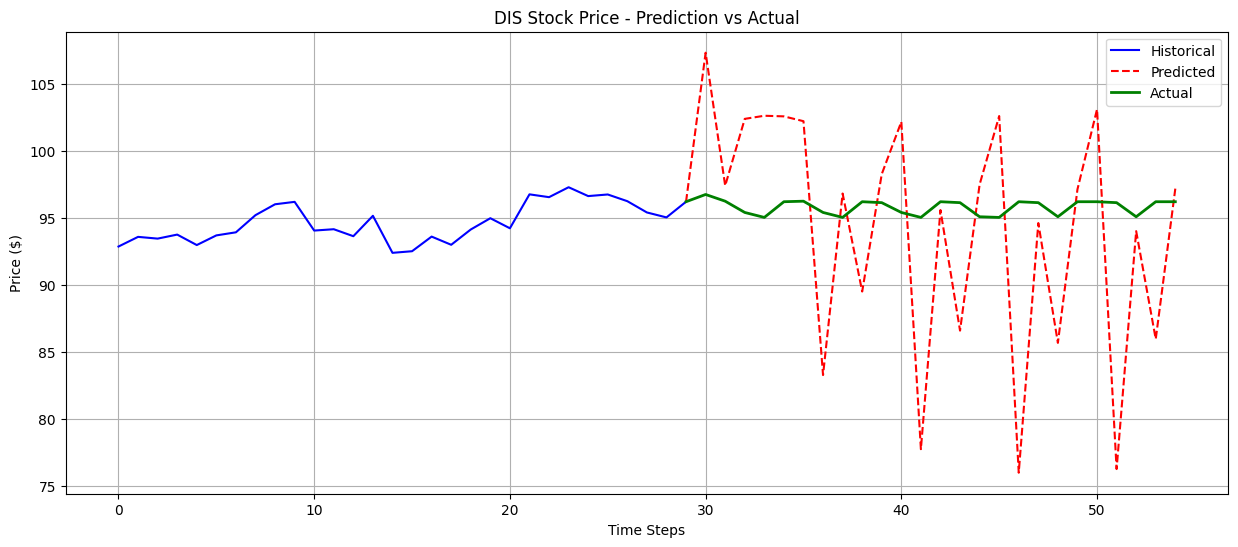


Predicting future prices for BA...

BA - Next 5 days price predictions:
Day 1: $166.08
Day 2: $156.85
Day 3: $162.53
Day 4: $163.11
Day 5: $162.88
Day 6: $159.73
Day 7: $142.09
Day 8: $154.49
Day 9: $147.58
Day 10: $155.47
Day 11: $159.17
Day 12: $135.95
Day 13: $151.94
Day 14: $142.97
Day 15: $153.36
Day 16: $158.77
Day 17: $133.45
Day 18: $149.72
Day 19: $140.87
Day 20: $151.70
Day 21: $158.32
Day 22: $132.77
Day 23: $147.98
Day 24: $140.07
Day 25: $150.44

BA - Actual prices for comparison:
Day 1: $159.88
Day 2: $157.06
Day 3: $155.20
Day 4: $155.01
Day 5: $150.69
Day 6: $157.06
Day 7: $155.20
Day 8: $155.01
Day 9: $150.69
Day 10: $152.98
Day 11: $155.20
Day 12: $155.01
Day 13: $150.69
Day 14: $152.98
Day 15: $154.29
Day 16: $155.01
Day 17: $150.69
Day 18: $152.98
Day 19: $154.29
Day 20: $149.31
Day 21: $150.69
Day 22: $152.98
Day 23: $154.29
Day 24: $149.31
Day 25: $149.31


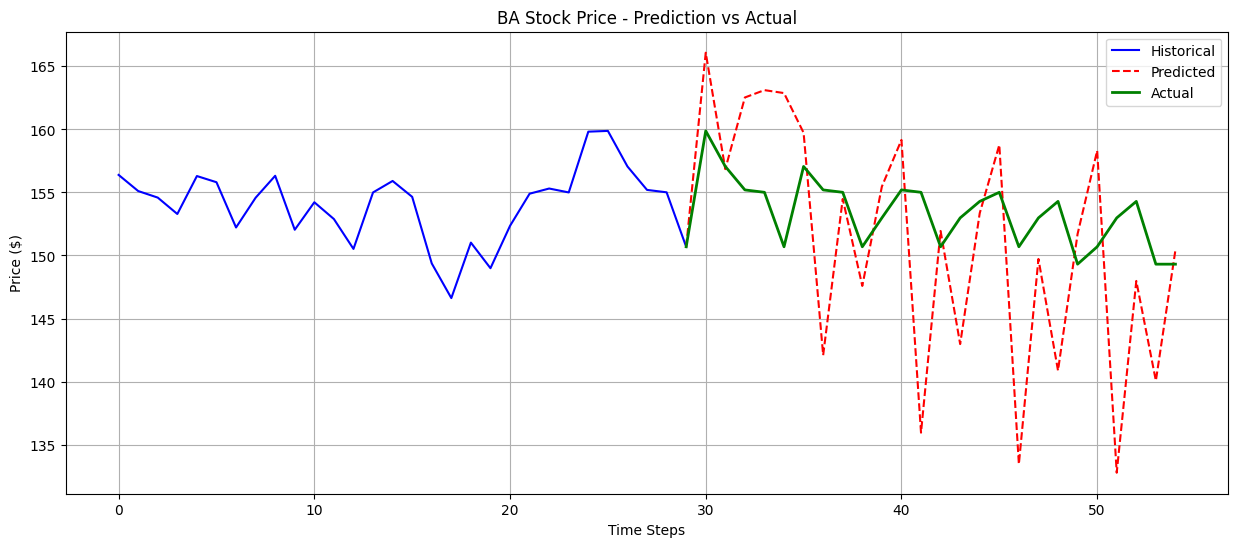


Predicting future prices for XOM...

XOM - Next 5 days price predictions:
Day 1: $129.89
Day 2: $120.95
Day 3: $126.03
Day 4: $126.20
Day 5: $125.25
Day 6: $127.70
Day 7: $109.04
Day 8: $121.28
Day 9: $116.05
Day 10: $122.84
Day 11: $127.51
Day 12: $103.69
Day 13: $119.08
Day 14: $112.89
Day 15: $122.28
Day 16: $127.64
Day 17: $101.77
Day 18: $117.66
Day 19: $111.72
Day 20: $121.81
Day 21: $127.92
Day 22: $101.73
Day 23: $116.98
Day 24: $111.67
Day 25: $121.50

XOM - Actual prices for comparison:
Day 1: $120.70
Day 2: $120.27
Day 3: $119.59
Day 4: $119.49
Day 5: $118.90
Day 6: $120.27
Day 7: $119.59
Day 8: $119.49
Day 9: $118.90
Day 10: $117.28
Day 11: $119.59
Day 12: $119.49
Day 13: $118.90
Day 14: $117.28
Day 15: $116.69
Day 16: $119.49
Day 17: $118.90
Day 18: $117.28
Day 19: $116.69
Day 20: $116.78
Day 21: $118.90
Day 22: $117.28
Day 23: $116.69
Day 24: $116.78
Day 25: $116.78


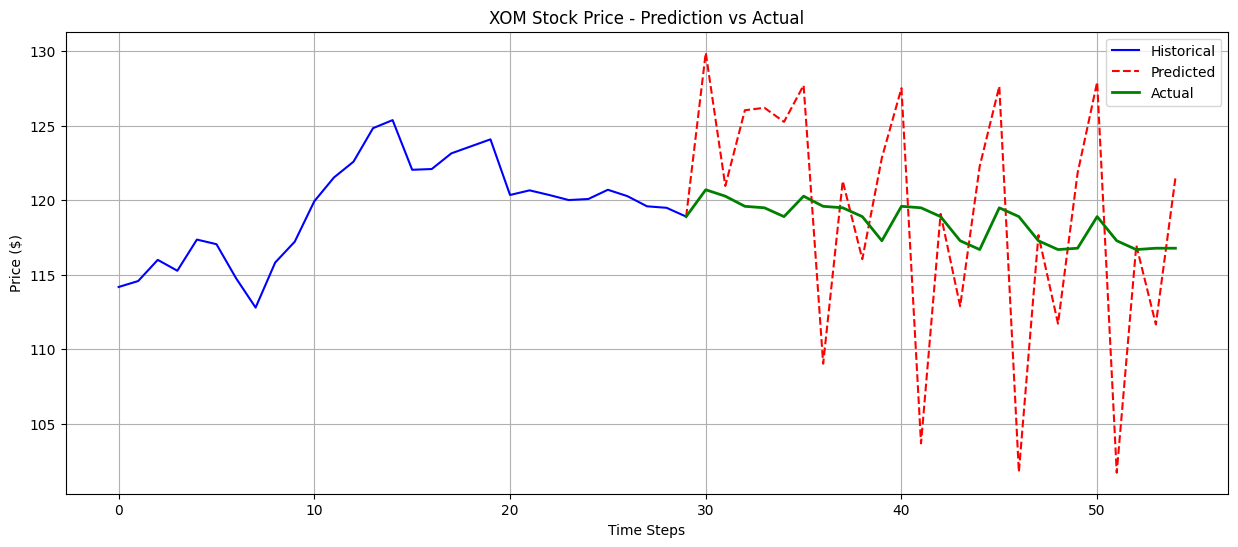


Predicting future prices for ORCL...

ORCL - Next 5 days price predictions:
Day 1: $188.95
Day 2: $177.61
Day 3: $183.77
Day 4: $184.41
Day 5: $184.15
Day 6: $179.11
Day 7: $163.39
Day 8: $172.39
Day 9: $169.55
Day 10: $174.97
Day 11: $175.96
Day 12: $156.08
Day 13: $167.77
Day 14: $164.50
Day 15: $171.67
Day 16: $173.71
Day 17: $151.89
Day 18: $164.36
Day 19: $160.79
Day 20: $168.41
Day 21: $171.86
Day 22: $149.40
Day 23: $161.74
Day 24: $158.06
Day 25: $165.55

ORCL - Actual prices for comparison:
Day 1: $175.31
Day 2: $173.10
Day 3: $174.38
Day 4: $173.52
Day 5: $172.42
Day 6: $173.10
Day 7: $174.38
Day 8: $173.52
Day 9: $172.42
Day 10: $173.43
Day 11: $174.38
Day 12: $173.52
Day 13: $172.42
Day 14: $173.43
Day 15: $174.56
Day 16: $173.52
Day 17: $172.42
Day 18: $173.43
Day 19: $174.56
Day 20: $167.84
Day 21: $172.42
Day 22: $173.43
Day 23: $174.56
Day 24: $167.84
Day 25: $167.84


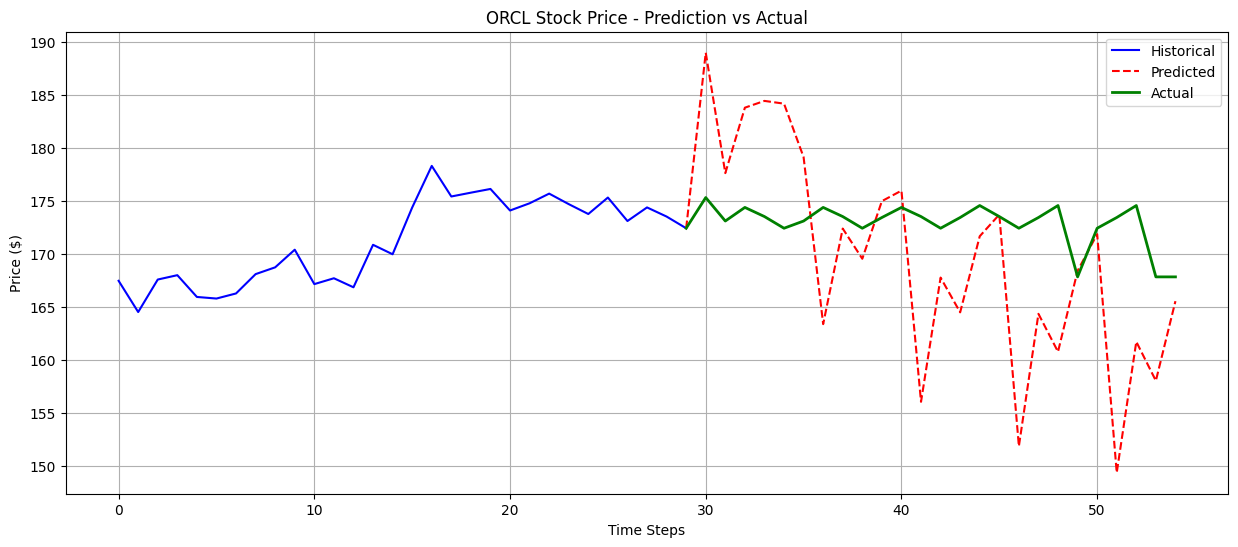


Predicting future prices for META...

META - Next 5 days price predictions:
Day 1: $552.47
Day 2: $552.36
Day 3: $534.29
Day 4: $534.20
Day 5: $536.96
Day 6: $520.67
Day 7: $531.65
Day 8: $495.03
Day 9: $502.86
Day 10: $491.14
Day 11: $494.34
Day 12: $509.14
Day 13: $466.40
Day 14: $482.50
Day 15: $462.32
Day 16: $471.02
Day 17: $484.76
Day 18: $442.57
Day 19: $460.62
Day 20: $437.72
Day 21: $450.15
Day 22: $460.45
Day 23: $421.97
Day 24: $439.03
Day 25: $416.14

META - Actual prices for comparison:
Day 1: $582.01
Day 2: $563.69
Day 3: $567.78
Day 4: $573.25
Day 5: $578.16
Day 6: $563.69
Day 7: $567.78
Day 8: $573.25
Day 9: $578.16
Day 10: $593.28
Day 11: $567.78
Day 12: $573.25
Day 13: $578.16
Day 14: $593.28
Day 15: $591.80
Day 16: $573.25
Day 17: $578.16
Day 18: $593.28
Day 19: $591.80
Day 20: $567.58
Day 21: $578.16
Day 22: $593.28
Day 23: $591.80
Day 24: $567.58
Day 25: $567.58


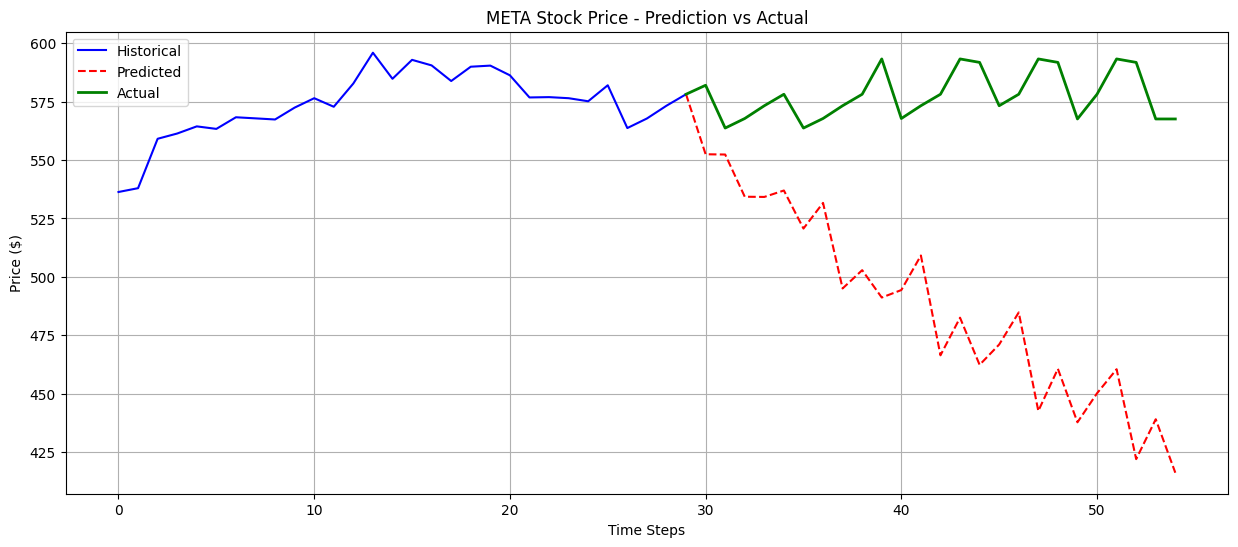

time: 17.3 s (started: 2024-11-18 08:00:27 +00:00)


In [20]:
def plot_future_predictions(historical_data, future_preds, actual_prices, ticker, scaler):
    """
    Plot historical data, future predictions, and actual prices in different colors
    
    Parameters:
    - historical_data: Historical price data
    - future_preds: Model's price predictions
    - actual_prices: Actual prices for the prediction period
    - ticker: Stock ticker symbol
    - scaler: The scaler used to transform the data
    """
    plt.figure(figsize=(15, 6))
    
    # Convert to actual prices
    historical_prices = inverse_transform_price(historical_data, scaler)
    future_prices = inverse_transform_price(future_preds.flatten(), scaler)
    actual_future_prices = inverse_transform_price(actual_prices.flatten(), scaler)
    
    # Plot historical data
    plt.plot(range(len(historical_prices)), historical_prices, label='Historical', color='blue')
    
    # Plot predictions
    connection_indices = range(len(historical_prices)-1, len(historical_prices) + len(future_prices))
    connection_points = np.concatenate([historical_prices[-1:], future_prices])
    plt.plot(connection_indices, connection_points, label='Predicted', color='red', linestyle='--')
    
    # Plot actual future prices (starting from the last historical point)
    actual_indices = range(len(historical_prices)-1, len(historical_prices) + len(actual_future_prices))
    actual_points = np.concatenate([historical_prices[-1:], actual_future_prices])
    plt.plot(actual_indices, actual_points, label='Actual', color='green', linewidth=2)
    
    plt.title(f'{ticker} Stock Price - Prediction vs Actual')
    plt.xlabel('Time Steps')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


def predict_future(model, last_sequence, n_steps_out, n_features):
    """
    Make future predictions using the last known sequence
    
    Args:
        model: trained LSTM model
        last_sequence: last known sequence of data (shape: [n_steps_in, n_features])
        n_steps_out: number of future steps to predict
        n_features: number of features in the input data
    """
    future_predictions = []
    current_sequence = last_sequence.reshape(1, n_steps_in, n_features)
    
    for _ in range(n_steps_out):
        # Get prediction for next step
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0])
        
        # Update the sequence by removing the first timestep and adding the prediction
        # We'll repeat the last prediction across all features as an approximation
        new_row = np.repeat(next_pred[0][0], n_features).reshape(1, 1, n_features)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], new_row], axis=1)
    
    return np.array(future_predictions)

# Future predictions
print("\nMaking Future Predictions...")
n_features = train_X.shape[2]

for i, ticker in enumerate(tickers):
    print(f"\nPredicting future prices for {ticker}...")
    
    # Get the last sequence from the validation data
    last_sequence = val_X_list[i][-1]
    
    # Make future predictions
    future_preds = predict_future(model, last_sequence, n_steps_out, n_features)
    
    # Get recent historical data for plotting (last 30 days)
    historical_data = val_y_list[i][-30:, 0]
    
    # Get actual future prices for comparison (next n_steps_out days)
    actual_future_prices = val_y_list[i][-n_steps_out:]
    
    # Print actual price predictions
    future_prices = inverse_transform_price(future_preds.flatten(), global_scaler)
    print(f"\n{ticker} - Next {n_steps_out} days price predictions:")
    for day, price in enumerate(future_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Print actual prices for comparison
    actual_prices = inverse_transform_price(actual_future_prices.flatten(), global_scaler)
    print(f"\n{ticker} - Actual prices for comparison:")
    for day, price in enumerate(actual_prices, 1):
        print(f"Day {day}: ${price:.2f}")
        
    # Plot future predictions with historical context and actual prices
    try:
        plot_future_predictions(historical_data,future_preds,actual_future_prices,ticker,global_scaler)
    except Exception as e:
        print(f"Error plotting predictions for {ticker}: {e}")
        continue
